In [1]:
#fetch command line argument (prepped model)
#%reset
import sys
import os
from copy import deepcopy
import pickle
import torch
import plotly.offline as py
import plotly.graph_objs as go


sys.path.insert(0, os.path.abspath('./prep_model_scripts/'))
sys.path.insert(0, os.path.abspath('./visualizer_scripts/'))
from visualizer_helper_functions import *
from contrast_helper_functions import *
from featureviz_helper_functions import *
from ablation_functions import *
from receptive_field import *
from dissected_Conv2d import *
from copy import deepcopy


py.init_notebook_mode(connected=True)   #jupyter notebook only

prepped_model_folder = 'alexnet_sparse'    #set this to a subfolder of prunned_models

full_prepped_model_folder = os.path.abspath('prepped_models/%s'%prepped_model_folder)

possible_models = os.listdir('prepped_models')
print('possible models to visualizer are:')
print(possible_models)

print('\nYou\'ve chosen to visualize %s'%prepped_model_folder)


sys.path.insert(0,'prepped_models/%s'%prepped_model_folder)

import prep_model_params_used as prep_model_params

params = {}
params['prepped_model'] = prepped_model_folder
params['prepped_model_path'] = full_prepped_model_folder

possible models to visualizer are:
['mnist_resize', 'alexnet_old.tar.gz', 'mnist_old', '.keep', 'mnist', 'old', 'alexnet10', 'letter_mixed_not_trained', 'imagenet10_sparse', 'alexnet_sparse_test', '.DS_Store', 'alexnet_sparse_full_model_10classes', 'imagenet10', 'alexnet_sparse', 'alexnet_lucent', 'mnist.tgz', 'alexnet', 'letter_mixed', 'googlenet10_test', '._.DS_Store', 'alexnet_corrupted', 'alexnet.tar.gz']

You've chosen to visualize alexnet_sparse


In [2]:
#Parameters

#Non-GUI parameters

#deepviz
params['deepviz_param'] = None
params['deepviz_optim'] = None
params['deepviz_transforms'] = None
params['deepviz_image_size'] = prep_model_params.deepviz_image_size

#backend
params['cuda'] = prep_model_params.cuda    #use gpu acceleration when running model forward
params['input_image_directory'] = prep_model_params.input_img_path+'/'   #path to directory of imput images you want fed through the network
params['preprocess'] = prep_model_params.preprocess     #torchvision transfrom to pass input images through
params['label_file_path'] = prep_model_params.label_file_path
params['criterion'] = prep_model_params.criterion
params['rank_img_path'] = prep_model_params.rank_img_path
params['num_workers'] = prep_model_params.num_workers
params['seed'] = prep_model_params.seed
params['batch_size'] = prep_model_params.batch_size
#params['dynamic_act_cache_num'] = 4  #max number of input image activations 'dynamic_activations' will have simultaneously

 
#aesthetic 

params['node_size'] = 12
params['edge_size'] = 1
params['max_node_inputs'] = 10    #there is a dropdown showing the top weighted edge inputs to nodes, how many maps in dropdown?
params['layer_colors'] = ['rgba(31,119,180,', 
                          'rgba(255,127,14,',
                          'rgba(44,160,44,', 
                          'rgba(214,39,40,',
                          'rgba(39, 208, 214,', 
                          'rgba(242, 250, 17,',
                          'rgba(196, 94, 255,',
                          'rgba(193, 245, 5,',
                          'rgba(245, 85, 5,',
                          'rgba(5, 165, 245,',
                          'rgba(245, 5, 105,',
                          'rgba(218, 232, 23,',
                          'rgba(148, 23, 232,',
                          'rgba(23, 232, 166,',]




#GUI parameters initialization (these parameters can be set in the GUI, but what values should they be initialized to?)
target_category = 'overall'     #category of images edges and nodes are weighted based on (which subgraph) 
rank_type = 'actxgrad'       #weighting criterion (actxgrad, act, grad, or weight)
projection = 'MDS smooth'           #how nodes within a layer are projected into the 2d plane (MDS or Grid)
edge_threshold = [.7,1]     #what range do edge ranks need to be in to be visualized


#### DONT EDIT BELOW initializations

figure_init = go.Figure()
figure_init.add_trace(go.Scatter(
            x=[],
            y=[]))
figure_init.update_layout(xaxis=dict(visible=False),
                  yaxis=dict(visible=False),
                  annotations = [dict(text="No Inputs",
                                      xref="paper",
                                      yref="paper",
                                      showarrow=False,
                                      font=dict(size=28))]
                 )

params['max_edge_weight'] = 1  #for the edge threshold slider, this dynamically adjusted its max value to max edge rank
                     #before there were multiple rank criterions, which made things confusing
                     #so well just fix it to 1 for now

In [3]:
#load Model

model_dis = dissect_model(deepcopy(prep_model_params.model),store_ranks=True,clear_ranks=True,cuda=params['cuda']) #version of model with accessible preadd activations in Conv2d modules 
if params['cuda']:
    model_dis.cuda()
model_dis = model_dis.eval()    

print('loaded model:')
print(prep_model_params.model)
        
#del prep_model_params.model
model = prep_model_params.model
if params['cuda']:
    model.cuda()
model = model.eval()


loaded model:
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096

In [4]:
#load misc graph data
print('loading misc graph data')
misc_data = pickle.load(open('./prepped_models/%s/misc_graph_data.pkl'%prepped_model_folder,'rb'))
params['layer_nodes'] = misc_data['layer_nodes']
params['num_layers'] = misc_data['num_layers']
params['num_nodes'] = misc_data['num_nodes']
params['categories'] = misc_data['categories']
params['num_img_chan'] = misc_data['num_img_chan']
params['imgnode_positions'] = misc_data['imgnode_positions']
params['imgnode_colors'] = misc_data['imgnode_colors']
params['imgnode_names'] = misc_data['imgnode_names']
params['prepped_model_path'] = full_prepped_model_folder
params['ranks_data_path'] = full_prepped_model_folder+'/ranks/'


print('model has categories:')
print(params['categories'])

loading misc graph data
model has categories:
['overall', 'Afghan_hound', 'African_chameleon', 'African_crocodile', 'African_elephant', 'African_grey', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'American_alligator', 'American_black_bear', 'American_chameleon', 'American_coot', 'American_egret', 'American_lobster', 'Angora', 'Appenzeller', 'Arabian_camel', 'Arctic_fox', 'Australian_terrier', 'Band_Aid', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'CD_player', 'Cardigan_corgi', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Christmas_stocking', 'Crock_Pot', 'Dandie_Dinmont', 'Doberman', 'Dungeness_crab', 'Dutch_oven', 'Egyptian_cat', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'European_fire_salamander', 'European_gallinule', 'French_bulldog', 'French_horn', 'French_loaf', 'German_shepherd

In [5]:
#load nodes df
print('loading nodes rank data')
target_node = 'loss'

categories_nodes_df = pd.read_csv('prepped_models/%s/ranks/categories_nodes_ranks.csv'%prepped_model_folder)
target_nodes_df = categories_nodes_df.loc[categories_nodes_df['category']==target_category]

target_nodes_df = minmax_normalize_ranks_df(target_nodes_df,params,weight=False)

weight_nodes_df = pd.read_csv('prepped_models/%s/ranks/weight_nodes_ranks.csv'%prepped_model_folder)

weight_nodes_df = minmax_normalize_ranks_df(weight_nodes_df,params,weight=True)

node_colors,node_weights = gen_node_colors(target_nodes_df,rank_type,params) 

#load node positions
print('loading node position data')
all_node_positions = pickle.load(open('./prepped_models/%s/node_positions.pkl'%prepped_model_folder,'rb'))

if projection == 'Grid':
    node_positions = all_node_positions[projection]
else:
    node_positions = all_node_positions[projection][rank_type]



loading nodes rank data


/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/visualizer_scripts/visualizer_helper_functions.py:146: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



loading node position data


In [6]:
#load edges
print('loading edge data')

categories_edges_df = None
if os.path.exists('prepped_models/%s/edge_ranks.csv'%prepped_model_folder):
    categories_edges_df = pd.read_csv('prepped_models/%s/ranks/categories_edges_ranks.csv'%prepped_model_folder)   #load edges

if categories_edges_df is not None:
    #overall_edges_df = categories_edges_df.loc[categories_edges_df['category']=='overall']
    target_edges_df = categories_edges_df.loc[categories_edges_df['category']==target_category]
else:
    #overall_edges_df = rank_file_2_df(os.path.join(params['ranks_data_path'],'categories_edges','overall_edges_rank.pt'))
    target_edges_df = rank_file_2_df(os.path.join(params['ranks_data_path'],'categories_edges','%s_edges_rank.pt'%target_category))

target_edges_df = minmax_normalize_ranks_df(target_edges_df,params,weight=False)

weight_edges_df = pd.read_csv('prepped_models/%s/ranks/weight_edges_ranks.csv'%prepped_model_folder)
  
weight_edges_df = minmax_normalize_ranks_df(weight_edges_df,params,weight=True)    
    
edges_thresholded_df = get_thresholded_edges(edge_threshold,rank_type,target_edges_df,target_category)
 
    
num_edges = len(target_edges_df)
edges_df_columns = list(target_edges_df.columns)

edge_positions, edge_colors, edge_widths, edge_weights, edge_names, max_edge_width_indices = gen_edge_graphdata(edges_thresholded_df, node_positions, rank_type, target_category,params)

loading edge data


In [7]:
#Load Edge Kernels
print('loading convolutional kernels')
kernels = torch.load('prepped_models/%s/kernels.pt'%prepped_model_folder)

loading convolutional kernels


In [8]:
#Input Image names
params['input_image_directory'] = prep_model_params.input_img_path+'/'
params['input_image_list'] = os.listdir(params['input_image_directory'])
params['input_image_list'].sort()
input_image_name = params['input_image_list'][0]

In [9]:
receptive_fields = None
if os.path.exists('prepped_models/%s/receptive_fields.pkl'%prepped_model_folder):
    receptive_fields = pickle.load(open('prepped_models/%s/receptive_fields.pkl'%prepped_model_folder,'rb'))
    
input_image_size = 224   #got to figure out a way not to hard-code this
receptive_fields

OrderedDict([('features_-1',
              OrderedDict([('j', 1.0),
                           ('r', 1.0),
                           ('start', 0.5),
                           ('conv_stage', True),
                           ('output_shape', [-1, 3, 224, 224])])),
             ('features_0',
              OrderedDict([('j', 4.0),
                           ('r', 11.0),
                           ('start', 3.5),
                           ('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 55, 55])])),
             ('features_1',
              OrderedDict([('j', 4.0),
                           ('r', 11.0),
                           ('start', 3.5),
                           ('input_shape', [-1, 64, 55, 55]),
                           ('output_shape', [-1, 64, 55, 55])])),
             ('features_2',
              OrderedDict([('j', 8.0),
                           ('r', 19.0),
                           ('start', 7.5),
                           

In [10]:
#Format Node Feature Maps
print('loading activation maps')

all_activations = {'nodes':{},'edges_in':{},'edges_out':{}}
if os.path.exists('prepped_models/%s/input_img_activations.pt'%prepped_model_folder):
    all_activations = torch.load('prepped_models/%s/input_img_activations.pt'%prepped_model_folder)


loading activation maps


In [11]:
#hidden state, stores python values within the html itself
state = {'projection':projection,'rank_type':rank_type,'edge_positions':edge_positions,'edge_colors': edge_colors, 'edge_widths':edge_widths,'edge_names':edge_names,
         'edge_threshold':edge_threshold,'edge_weights':edge_weights,'max_edge_width_indices':max_edge_width_indices,
         'node_positions':node_positions,'node_colors':node_colors,'node_weights':node_weights,'target_category':target_category,'target_node':'loss',
         'node_select_history':['0'],'edge_select_history':[edge_names[0][0]],'last_trigger':None,'input_image_name':input_image_name,
         'imgnode_positions':params['imgnode_positions'],'imgnode_colors':params['imgnode_colors'],'imgnode_names':params['imgnode_names']}


In [12]:
#App Component Layouts
axis=dict(showbackground=False,
          showspikes=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          #range=[0,0],
          title=''
          )

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.00, y=-1.25, z=1.25)
)


network_graph_layout = go.Layout(
         #title="%s through Prunned Cifar10 CNN"%target_category,
         #title = target_category,
         #width=1000,
         clickmode = 'event+select',
         transition = {'duration': 20},
         height=500,
         #showlegend=False,
         margin = dict(l=20, r=20, t=20, b=20),
         scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
             aspectmode ="manual", 
             aspectratio = dict(x=1, y=0.5, z=0.5) #adjusting this stretches the network layer-to-layer
         ),
         scene_camera = camera,
         uirevision =  True   
         #hovermode='closest',
   )


input_image_layout = go.Layout(#width=200, 
                      #height=200,
                      uirevision = True,
                      margin=dict(
                        l=12,
                        r=1,
                        b=12,
                        t=1,
                        pad=10
                        ),
                        paper_bgcolor='rgba(0,0,0,0)',
                        plot_bgcolor='rgba(0,0,0,0)',
                        xaxis=dict(range=(0,10),showline=False,showgrid=False,showticklabels=False),
                        yaxis=dict(range=(0,10),showline=False,showgrid=False,showticklabels=False))


node_actmap_layout = go.Layout(
    #autosize=False,
    #width=270,
    #height=200,
    uirevision = True,
    margin=dict(
        l=1,
        r=1,
        b=1,
        t=1,
        pad=1
    ))


edge_inmap_layout = go.Layout(
    #title = 'edge input map',
    #autosize=False,
    #width=270,
    #height=200,
    uirevision = True,
    margin=dict(
        l=1,
        r=1,
        b=1,
        t=10,
        pad=1
    ))


edge_outmap_layout = go.Layout(
    #title = 'edge output map',
    #autosize=False,
    #width=270,
    #height=200,
    uirevision = True,
    margin=dict(
        l=1,
        r=1,
        b=1,
        t=10,
        pad=1
    ))


kernel_layout = go.Layout(
    #title='kernel'
    #autosize=False,
    #width=180,
    #height=120,
    uirevision = True,
    margin=dict(
        l=1,
        r=1,
        b=1,
        t=1,
        pad=1
    ))


In [13]:
#Generate Network Graph
combined_traces = gen_networkgraph_traces(state,params)
network_graph_fig=go.Figure(data=combined_traces, layout=network_graph_layout)

building graph from browser "state"


In [14]:
#Dash App Setup
print('setting up dash app')

import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_daq as daq
from dash.exceptions import PreventUpdate
#import utils.dash_reusable_components as drc
import flask
import os

import json

from dash.dependencies import Input, Output, State

from plotly.subplots import make_subplots

from flask_caching import Cache

#external_stylesheets = ['https://codepen.io/amyoshino/pen/jzXypZ.css']
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(external_stylesheets = external_stylesheets)



if not os.path.exists(full_prepped_model_folder+'/cache/'):
    os.mkdir(full_prepped_model_folder+'/cache/')
CACHE_CONFIG = {
    # try 'filesystem' if you don't want to setup redis
    'CACHE_TYPE': 'filesystem',
    'CACHE_DIR': full_prepped_model_folder+'/cache/'}
cache = Cache()
cache.init_app(app.server, config=CACHE_CONFIG)
    


styles = {
    'pre': {
        'border': 'thin lightgrey solid',
        'overflowX': 'scroll'
    }
}


theme =  {
    'dark': True,
    'detail': '#007439',
    'primary': '#00EA64',
    'secondary': '#6E6E6E',
}


app.layout = html.Div([
        html.Div(
            children = [
                
            html.Div(
                #Left side control panel
                children = [
                 html.Label('Subgraph Controls', style={'fontSize': 18,'font-weight':'bold'}),
                 html.Br(),
                 html.Label('Input'),
                 #dcc.Dropdown(
                 #  id='weight-category',
                 #  options=[{'label': i, 'value': i} for i in params['categories']],
                 #   value=target_category
                 #   ),
                dcc.Input(id='input-category',value=state['target_category']),
                html.Br(),
                html.Br(),
                html.Label('Output'),
                 #dcc.Dropdown(
                 #  id='weight-category',
                 #  options=[{'label': i, 'value': i} for i in params['categories']],
                 #   value=target_category
                 #   ),
                dcc.Dropdown(
                    id='target-node',
                    options=[
                    {'label': i, 'value': i} for i in ['loss']+[str(node) for node in list(range(params['num_nodes']))]
                    ],
                    value=state['target_node']),
                 html.Br(),
                 html.Label('Subgraph Criterion'),
                 dcc.Dropdown(
                    id='subgraph-criterion',
                    options=[
                        {'label': 'Activations*Grads', 'value': 'actxgrad'},
                        {'label': 'Activations', 'value': 'act'},
                        {'label': 'Gradients', 'value': 'grad'},
                        {'label': 'Weights', 'value': 'weight'}
                    ],
                    value='actxgrad'
                    ),
                 html.Br(),   
                 html.Label('Layer Projection'),
                 dcc.Dropdown(
                    id = 'layer-projection',
                    options=[
                        {'label': 'MDS', 'value': 'MDS'},
                        {'label': 'MDS smooth', 'value': 'MDS smooth'},
                        {'label': 'Grid', 'value': 'Grid'},
                        #{'label': 'SOM', 'value': 'SOM'}
                    ],
                    value='MDS smooth'
                    ),

                html.Br(),
                html.Label('Edge Thresholds'),
                    dcc.RangeSlider(
                        id='edge-thresh-slider',
                        min=0,
                        max=np.ceil(params['max_edge_weight']*10)/10,
                        step=0.001,
                        marks={i/10: str(i/10) for i in range(0,int(np.ceil(params['max_edge_weight']*10))+1,int(round(np.ceil(params['max_edge_weight']*10)/5)))},
                        value=[.7,np.ceil(params['max_edge_weight']*10)/10],
                    ),

                ], className="two columns",
                ),
                
            html.Div([
                dcc.Graph(
                    id='network-graph',
                    figure=network_graph_fig
                )
                ], className= 'ten columns'
                ),
            ], className="row"
        ),


                
        html.Div([
            html.Div([
            html.Label('Input Image', style={'fontSize': 18,'font-weight':'bold'}),
            dcc.Dropdown(id="dynamic-input-image-dropdown",value=params['input_image_list'][0]),
            #dcc.Dropdown(
            #    id='input-image-dropdown',
            #    options=[{'label': i, 'value': i} for i in params['input_image_list']+os.listdir(params['prepped_model_path']+'/visualizations/images/')],
            #    value=input_image_name
            #),
            html.Br(),
            dcc.Graph(
                id='img-actmap-graph',
                style={
               'width': '14vw',
               'height':'14vw'
                },
                figure=image2heatmap(params['input_image_directory']+input_image_name,input_image_layout),
                config={
                        'displayModeBar': False
                        }
            )
            ], className = "two columns"),

            html.Div([
            html.Label('Node', style={'fontSize': 18,'font-weight':'bold'}),
            dcc.Dropdown(
                id='node-actmap-dropdown',
                options=[{'label': str(j), 'value': str(j)} for j in params['imgnode_names']]+[{'label': str(i), 'value': str(i)} for i in range(params['num_nodes'])],
                value='0'
            ),
            html.Br(),
            dcc.Graph(
                id='node-actmap-graph',
                style={
               'width': '18vw',
               'height':'14vw'
                },
                figure=figure_init,
                config={
                        'displayModeBar': False
                        }
            ),
            dcc.Checklist(
                id = 'relu-checkbox',
                options = [{'label':'relu','value':'relu'}],
                value = []
                
            ),
            html.Div(id='node-sum', style={'whiteSpace': 'pre-line'}),
            html.Br(),
            html.Br(),
            dcc.Graph(
                id='node-deepviz-image',
                style={
               'width': '14vw',
               'height':'14vw'
                },
                figure=figure_init,
                config={
                        'displayModeBar': False
                        }
            )
            ], className = "three columns"),
            
            html.Div([
            html.Label('Node Inputs', style={'fontSize': 18,'font-weight':'bold'}),
            html.Br(),
            html.Div(dcc.Graph(
                id='node-inputs-graph',
                figure=figure_init,
                config={
                        'displayModeBar': False
                        }
            ),style={'overflowY': 'scroll', 'height': 500})
            ], className = "three columns"),

            html.Div([
            html.Label('Edge', style={'fontSize': 18,'font-weight':'bold'}),    
            dcc.Input(
                id='edge-actmaps-input',value=state['edge_names'][0][0], type='text'),
            #html.Button(id='edge-kernel-button',n_clicks=0, children='Submit'),
            html.Br(),
            html.Br(),
            html.Label('Kernel'),
            dcc.Graph(
                id='edge-kernel-graph',
                style={
               'width': '14vw',
               'height':'10vw'
                },
                figure=go.Figure(data=go.Heatmap(
                                    z = edgename_2_edge_figures(state['edge_names'][0][0], input_image_name, kernels, None,params)[0]),
                                 layout=kernel_layout
                                ),
                config={
                        'displayModeBar': False
                        }
            ),
            html.Br(),
            html.Br(),
            dcc.Graph(
               id='edge-deepviz-image',
               style={
              'width': '14vw',
              'height':'14vw'
               },
               figure=figure_init,
               config={
                       'displayModeBar': False
                       }
            )
            ], className = "two columns"),


            html.Div([
            html.Label('Edge Input'),
            html.Br(),
            dcc.Graph(
                id='edge-inmap-graph',
                style={
               'width': '18vw',
               'height':'14vw'
                },
                figure=figure_init,
                config={
                        'displayModeBar': False
                        }
            ),
            html.Div(id='edgein-sum', style={'whiteSpace': 'pre-line'}),
            html.Br(),
            html.Br(),
            html.Label('Edge Output'),
            html.Br(),
            dcc.Graph(
                id='edge-outmap-graph',
                style={
               'width': '18vw',
               'height':'14vw'
                },
                figure=figure_init,
                config={
                        'displayModeBar': False
                        }
            ),
            html.Div(id='edgeout-sum', style={'whiteSpace': 'pre-line'}),

            ], className = "two columns")


         ], className= 'row'
         ),
    
    
    html.Div([
            html.Div([
            html.Label('Image Manipulations', style={'fontSize': 18,'font-weight':'bold'}),
            html.Br(),
            html.Label('rotation'),
            dcc.Slider(
                id='image-rotation-slider',
                min=0,
                max=350,
                step=10,
                marks={
                        0:   '0°',
                        20:  '20°',
                        40:  '40°',
                        60:  '60°',
                        80:  '80°',
                        100: '100°',
                        120: '120°',
                        140: '140°',
                        160: '160°',
                        180: '180°',
                        200: '200°',
                        220: '220°',
                        240: '240°',
                        260: '260°',
                        280: '280°',
                        300: '300°',
                        320: '320°',
                        340: '240°',
                        },
                included=False,
                value=0,
            ),
            html.Br(),
            html.Label('scaling'),
            dcc.Slider(
                id='image-scaling-slider',
                min=-10,
                max=10,
                step=1,
                marks={
                        -8:  '.33',
                        -6:  '.4',
                        -4: '.5',
                        -2: '.67',
                         0: '1',
                         2: '1.5',
                         4: '2',
                         6: '2.5',
                         8: '3',
                        },
                included=False,
                value=0,
            ),            
            html.Br(),
            html.Label('colors'),

                    html.Label('R',style={'fontSize': 10,'font-weight':'italic'}),
                    dcc.Slider(
                        id='image-r-slider',
                        min=-1,
                        max=1,
                        step=.05,
                        marks={
                                -1:'-1',
                                -.8:'-.8',
                                -.6:'-.6',
                                -.4:'-.4',
                                 -.2:'-.2',
                                 0:'0',
                                 .2:'.2',
                                 .4:'.4',
                                 .6:'.6',
                                 .8:'.8',
                                  1:'1',
                                },
                        included=False,
                        value=0,
                    ),
 

                    html.Label('G',style={'fontSize': 10,'font-weight':'italic'}),
                    dcc.Slider(
                        id='image-g-slider',
                        min=-1,
                        max=1,
                        step=.05,
                        marks={
                                -1:'-1',
                                -.8:'-.8',
                                -.6:'-.6',
                                -.4:'-.4',
                                 -.2:'-.2',
                                 0:'0',
                                 .2:'.2',
                                 .4:'.4',
                                 .6:'.6',
                                 .8:'.8',
                                  1:'1',
                                },
                        included=False,
                        value=0,
                    ),
    

                    html.Label('B',style={'fontSize': 10,'font-weight':'italic'}),
                    dcc.Slider(
                        id='image-b-slider',
                        min=-1,
                        max=1,
                        step=.05,
                        marks={
                                -1:'-1',
                                -.8:'-.8',
                                -.6:'-.6',
                                -.4:'-.4',
                                 -.2:'-.2',
                                 0:'0',
                                 .2:'.2',
                                 .4:'.4',
                                 .6:'.6',
                                 .8:'.8',
                                  1:'1',
                                },
                        included=False,
                        value=0,
                    )
           
            ], className = "three columns"),
                
                
            html.Div([
            html.Label('Feature Visualizations', style={'fontSize': 18,'font-weight':'bold'}),
            html.Br(),
            html.Div( style=dict(display='flex'),
                children = [     
                    daq.ToggleSwitch(
                        id='featviz-nodeedge-toggle',
                        label=['node','edge    '],
                        style={'float': 'right','margin': 'auto'}
                        #labelPosition='bottom'
                    ), 
                    html.Label(''),
                    daq.ToggleSwitch(
                        id='featviz-channelneuron-toggle',
                        label=['channel','neuron    '],
                        style={'float': 'right','margin': 'auto'}
                        #labelPosition='bottom'
                    ),
                    html.Label(''),
                    daq.ToggleSwitch(
                        id='featviz-positivenegative-toggle',
                        label=['positive','negative    '],
                        style={'float': 'right','margin': 'auto'}
                        #labelPosition='bottom'
                    )
                ]),
            html.Br(),
            dcc.Graph(
               id='featviz-image',
               style={
              'width': '14vw',
              'height':'14vw'
               },
               figure=figure_init,
               config={
                       'displayModeBar': False
                       }
            ),
            html.Button('Generate', id='featviz-button')
            #html.Button('Generate', id='gen-featviz-button')
            ], className= "five columns"),
        
        
        
            html.Div([
            html.Label('Model Ablations', style={'fontSize': 18,'font-weight':'bold'}),
            dcc.Textarea(
                id='ablations-textarea',
                value='',
                style={'width': '70%', 'height': 300}),
            html.Button('Ablate', id='ablate-model-button')
            ], className= "four columns"),
        
        ], className="row"
        ),
                
#         html.Div([
#             html.Div([
#                 dcc.Markdown("""
#                     **Hover Data**

#                     Mouse over values in the graph.
#                 """),
#                 html.Pre(id='hover-data', style=styles['pre'])
#             ], className='two columns'),

#             html.Div([
#                 dcc.Markdown("""
#                     **Click Data**

#                     Click on points in the graph.
#                 """),
#                 html.Pre(id='click-data', style=styles['pre']),
#             ], className='two columns'),

#             html.Div([
#                 dcc.Markdown("""
#                     **Selection Data**

#                     Choose the lasso or rectangle tool in the graph's menu
#                     bar and then select points in the graph.

#                     Note that if `layout.clickmode = 'event+select'`, selection data also 
#                     accumulates (or un-accumulates) selected data if you hold down the shift
#                     button while clicking.
#                 """),
#                 html.Pre(id='selected-data', style=styles['pre']),
#             ], className='two columns'),

# #                 html.Div([
# #                     dcc.Markdown("""
# #                         **Zoom and Relayout Data**

# #                         Click and drag on the graph to zoom or click on the zoom
# #                         buttons in the graph's menu bar.
# #                         Clicking on legend items will also fire
# #                         this event.
# #                     """),
# #                     html.Pre(id='relayout-data', style=styles['pre']),
# #                 ], className='two columns')
                
#             html.Div([
#                 dcc.Markdown("""
#                     **Figure Data**

#                     Figure json info.
#                 """),
#                 html.Pre(id='figure-data', style=styles['pre']),
#             ], className='four columns')

#         ], className= 'row'
#         ),

    #hidden divs for storing intermediate values     
    # The memory store reverts to the default on every page refresh
    dcc.Store(id='memory',data=state),
    # The local store will take the initial data
    # only the first time the page is loaded
    # and keep it until it is cleared.
    #dcc.Store(id='local', storage_type='local'),
    # Same as the local store but will lose the data
    # when the browser/tab closes.
    #dcc.Store(id='session', storage_type='session',data=state),
    

    # hidden signal value
    html.Div(id='input-image-signal',  style={'display': 'none'}),
    html.Div(id='target-signal', style={'display': 'none'},children = [state['target_category'],state['target_node']]),
    html.Div(id='ablations-signal',  style={'display': 'none'}, children = [])
])



# perform expensive computations in this "global store"
# these computations are cached in a globally available
# 'cached' folder in the prepped_models/[model] folder
@cache.memoize()
def activations_store(image_name,ablation_list):

    print('Updating cached activations with {}'.format(image_name))
    activations = get_model_activations_from_image(get_image_path(image_name,params)[1], model_dis, params)
    
    return activations

@app.callback(Output('input-image-signal', 'children'), 
              [Input('dynamic-input-image-dropdown', 'value'),
               Input('ablations-signal', 'children')])
def update_activations_store(image_name,ablation_list):
    # compute value and send a signal when done
    activations_store(image_name,ablation_list)
    return image_name


@cache.memoize()
def ranksdf_store(target_category, target_node,ablation_list,model_dis=model_dis):
    print('Updating cached rank dfs with {}'.format(target_category))
    model_dis = clear_ranks_across_model(model_dis)
    target_type = image_category_or_contrast(target_category,params)
    target_category_nodes_df = None
    target_category_edges_df = None
    if target_type == 'category' and target_node == 'loss' and ablation_list == []:
        #edges
        if categories_edges_df is not None:
            if len(categories_edges_df.loc[categories_edges_df['category']==target_category]) > 0:
                target_category_edges_df = categories_edges_df.loc[categories_edges_df['category']==target_category]
        if target_category_edges_df is None:
            target_category_edges_df = rank_file_2_df(os.path.join(params['ranks_data_path'],'categories_edges','%s_edges_rank.pt'%target_category))   
        #node
        if categories_nodes_df is not None:
            if len(categories_nodes_df.loc[categories_nodes_df['category']==target_category]) > 0:
                target_category_nodes_df = categories_nodes_df.loc[categories_nodes_df['category']==target_category]
        if target_category_nodes_df is None:
            target_category_nodes_df = rank_file_2_df(os.path.join(params['ranks_data_path'],'categories_nodes','%s_nodes_rank.pt'%target_category))
    elif target_type == 'category':
        target_category_nodes_df,target_category_edges_df = rank_dict_2_df(get_model_ranks_for_category(target_category, target_node, model_dis,params))
    elif target_type == 'input_image':
        target_category_nodes_df,target_category_edges_df = rank_dict_2_df(get_model_ranks_from_image(get_image_path(target_category,params)[1],target_node, model_dis, params))

    else:  #contrast
        target_category_nodes_df,target_category_edges_df = contrast_str_2_dfs(target_category,target_node,model_dis,params,ablation_list)
    print('FROM RANKS DF STORE')
    print(target_category_edges_df)
    return target_category_nodes_df,target_category_edges_df

@app.callback(Output('target-signal', 'children'), 
              [Input('input-category', 'value'),
               Input('target-node','value'),
               Input('ablations-signal', 'children')])
def update_ranksdf_store(target_category,target_node,ablation_list):
    # compute value and send a signal when done
    print('update ranksdf_store triggered')
    ranksdf_store(target_category,target_node,ablation_list)
    return [target_category,target_node]



####Call Back Functions

#Ablations
@app.callback(Output('ablations-signal', 'children'), 
              [Input('ablate-model-button', 'n_clicks')],
              [State('ablations-textarea','value')])
def update_ablations(n_clicks,text,model_dis=model_dis):
    # compute value and send a signal when done
    ablation_list = ablation_text_2_list(text, params)
    ablate_model_with_list(ablation_list,model_dis,params)
    return ablation_list


#Hidden State
@app.callback(
    Output('memory', 'data'),
    [Input('target-signal', 'children'),
     Input('node-actmap-dropdown', 'value'),
     Input('edge-actmaps-input', 'value'),
     Input('edge-thresh-slider','value'),
     Input('layer-projection','value'),
     Input('subgraph-criterion','value')],
    [State('memory', 'data'),
     State('ablations-signal', 'children')])
def update_store(target,node_value,edge_value,edge_threshold,projection,rank_type,state,ablation_list):
    print('CALLED: update_store\n')
    ctx = dash.callback_context
    if not ctx.triggered:
        raise Exception('no figure updates yet')
    else:
        trigger = ctx.triggered[0]['prop_id']
    state['last_trigger'] = trigger  #store the last trigger of state change in state
    print('TRIGGER %s'%trigger)

    target_category,target_node = target[0],target[1]
    #fetch select edges DF
    if trigger in ['target-signal.children','edge-thresh-slider.value','layer-projection.value','subgraph-criterion.value']:
        if rank_type == 'weight':
            target_edges_df = weight_edges_df
            target_nodes_df = weight_nodes_df
            weight=True
        else:   
            target_nodes_df,target_edges_df = ranksdf_store(target_category,target_node,ablation_list)
            weight=False   
        target_edges_df = minmax_normalize_ranks_df(target_edges_df,params,weight=weight)
        target_nodes_df = minmax_normalize_ranks_df(target_nodes_df,params,weight=weight)
        print("MINMAX EDGES DF")
        print(target_edges_df)
        edges_thresholded_df = get_thresholded_edges(edge_threshold,rank_type,target_edges_df,target_category)

    if trigger == 'target-signal.children':
        print('changing target category to %s'%target_category)
        #print(target_nodes_df)
        state['node_colors'], state['node_weights'] = gen_node_colors(target_nodes_df,rank_type,params)
        #state['max_edge_weight'] = get_max_edge_weight(target_category)
        state['edge_positions'], state['edge_colors'], state['edge_widths'],state['edge_weights'], state['edge_names'], state['max_edge_width_indices'] = gen_edge_graphdata(edges_thresholded_df, state['node_positions'], rank_type, target_category,params)

    elif trigger == 'node-actmap-dropdown.value' or trigger == 'edge-actmaps-input.value':
        state['last_trigger'] = 'selection_change'
        print(edge_value)
        #update node if button value different than store value
        if state['node_select_history'][-1] != node_value:
            print('changing selected node to %s'%node_value)
            state['node_select_history'].append(node_value)
            if len(state['node_select_history']) > 10:
                del state['node_select_history'][0] 
        #update edge if button value different than store value
        if state['edge_select_history'][-1] != edge_value and check_edge_validity(edge_value.strip(),params)[0]:
            print('changing selected edge to %s'%edge_value)
            state['edge_select_history'].append(edge_value)
            print(state['edge_select_history'])
            if len(state['edge_select_history']) > 10:
                del state['edge_select_history'][0]              

    elif trigger == 'edge-thresh-slider.value':
        print('changing edge thresholds to %s - %s'%(edge_threshold[0],edge_threshold[1]))
        state['edge_threshold'] == edge_threshold
        print('found %s edges'%len(edges_thresholded_df))
        state['edge_positions'], state['edge_colors'], state['edge_widths'], state['edge_weights'], state['edge_names'], state['max_edge_width_indices'] = gen_edge_graphdata(edges_thresholded_df, state['node_positions'], rank_type, target_category,params)

    elif trigger == 'layer-projection.value':
        print('changing layer projection to %s\n'%projection)
        state['projection']=projection
        if projection == 'Grid':
            node_positions = all_node_positions[projection]
        else:
            node_positions = all_node_positions[projection][rank_type]
        state['edge_positions'], state['edge_colors'], state['edge_widths'],state['edge_weights'], state['edge_names'], state['max_edge_width_indices'] = gen_edge_graphdata(edges_thresholded_df, state['node_positions'], rank_type, target_category,params)

    elif trigger == 'subgraph-criterion.value':
        print('changing weighting criterion to %s\n'%rank_type)
        state['rank_type']=rank_type
        state['node_colors'], state['node_weights'] = gen_node_colors(target_nodes_df,rank_type,params)
        #state['node_positions']=format_node_positions(projection=projection,rank_type=rank_type)
        state['edge_positions'], state['edge_colors'], state['edge_widths'],state['edge_weights'], state['edge_names'], state['max_edge_width_indices'] = gen_edge_graphdata(edges_thresholded_df, state['node_positions'], rank_type, target_category,params)

    else:
        raise Exception('unknown trigger: %s'%trigger)    
    return state


#Network Graph Figure
@app.callback(
    Output('network-graph', 'figure'),
    [Input('memory', 'data')],
    [State('network-graph','figure')])
def update_figure(state, fig):
    #network_graph_layout['uirevision'] = True
    print('CALLED: update_figure\n')
    print(state['edge_threshold'])
    print(state['edge_select_history'])
    print(state['node_select_history'])
    if state['last_trigger'] == 'selection_change':   #minimal updates
        #hightlight edge
        print('updating edge highlight to %s'%state['edge_select_history'][-1])
        #if len(state['edge_select_history']) >1:
        #if state['edge_select_history'][-1] != state['edge_select_history'][-2]:  #didnt click same point
        flat_edge_names = [item for sublist in state['edge_names'] for item in sublist]
        flat_edge_colors = [item for sublist in state['edge_colors'] for item in sublist]
        try:  #update current edge if it exists to black
            #print(flat_edge_names)
            fig['data'][flat_edge_names.index(state['edge_select_history'][-1])+params['num_layers']+1]['line']['color'] = 'rgba(0,0,0,1)'
        except:
            print('select edge, %s,  not recolored as no longer shown'%state['edge_select_history'][-1])
        if len(state['edge_select_history']) > 1: #there is a previous edge to unselect
            try: #recolor previous edge if it exists from black
                fig['data'][flat_edge_names.index(state['edge_select_history'][-2])+params['num_layers']+1]['line']['color'] = flat_edge_colors[flat_edge_names.index(state['edge_select_history'][-2])]
            except:
                print('previous edge, %s,  not recolored as no longer shown'%state['edge_select_history'][-2])
        #highlight node
        print('updating node highlight to %s'%state['node_select_history'][-1])
        #if len(state['node_select_history']) >1:
        #    if state['node_select_history'][-1] != state['node_select_history'][-2]: 
                #update current node color to black
        if str(state['node_select_history'][-1]).isnumeric():  #if normal node
            select_layer,select_position,select_layer_name = nodeid_2_perlayerid(state['node_select_history'][-1],params)
            fig['data'][select_layer+1]['marker']['color'][select_position] = 'rgba(0,0,0,1)'
        else:   #imgnode
            fig['data'][0]['marker']['color'][fig['data'][0]['text'].index(state['node_select_history'][-1])] = 'rgba(0,0,0,1)'
        #update previous node color to its usual color
        if len(state['node_select_history']) > 1: #there is a previous node to unselect
            if str(state['node_select_history'][-2]).isnumeric():  #if normal node
                prev_select_layer,prev_select_position,prev_select_layer_name = nodeid_2_perlayerid(state['node_select_history'][-2],params)
                print(prev_select_layer,prev_select_position,prev_select_layer_name)
                fig['data'][prev_select_layer+1]['marker']['color'][prev_select_position] = state['node_colors'][prev_select_layer][prev_select_position]
            else:   #imgnode
                fig['data'][0]['marker']['color'][fig['data'][0]['text'].index(state['node_select_history'][-2])] = state['imgnode_colors'][fig['data'][0]['text'].index(state['node_select_history'][-2])]
        #fig['layout']['uirevision']=True   
        return fig    
    else:   #regenerate full traces
        combined_traces = gen_networkgraph_traces(state,params)
        fig['data'] = combined_traces
        #layout = network_graph_layout
        #layout['uirevision'] = True
        return fig

#Node Actmap Dropdown
@app.callback(
    Output('node-actmap-dropdown', 'value'),
    [Input('network-graph', 'clickData')],
    [State('node-actmap-dropdown', 'value')])
def switch_node_actmap_click(clickData,current_value):
    print('CALLED: switch_node_actmap_click')
    if clickData is None:
        return current_value 
        #raise Exception('no click data')
    if int(clickData['points'][0]['curveNumber']) > params['num_layers']:
        return current_value
        #raise Exception('edge was clicked')
    return clickData['points'][0]['text']

#Edge Actmaps Input
@app.callback(
    Output('edge-actmaps-input', 'value'),
    [Input('network-graph', 'clickData')],
    [State('edge-actmaps-input', 'value'),
     State('memory', 'data')])
def switch_edge_actmaps_click(clickData,current_value,state):
    print('CALLED: switch_edge_actmaps_click')
    if clickData is None:
        return current_value
        #raise Exception('no click data')
    if int(clickData['points'][0]['curveNumber']) <= params['num_layers']:
        return current_value
        #raise Exception('node was clicked')
    return get_nth_element_from_nested_list(state['edge_names'],int(clickData['points'][0]['curveNumber'])-(params['num_layers']+1))


#Node actmap graph
@app.callback(
    Output('node-actmap-graph', 'figure'),
    [Input('node-actmap-dropdown', 'value'),
     Input('relu-checkbox','value'),
     Input('input-image-signal', 'children')],
    [State('ablations-signal', 'children')])
def update_node_actmap(nodeid,relu_checked,image_name,ablation_list):       #EDIT: needs support for black and white images
    print('CALLED: update_node_actmap')
    layer, within_id,layer_name = nodeid_2_perlayerid(nodeid,params)
    #fetch activations
    if image_name in all_activations['nodes'] and ablation_list == []:
        activations = all_activations
    else:
        activations  = activations_store(image_name,ablation_list)
        
    if layer == 'img': #code for returning color channel as activation map
        #np_chan_im = get_channelwise_image(image_name,state['imgnode_names'].index(nodeid),params['input_image_directory']=params['input_image_directory'])
        np_chan_im = activations['edges_in'][image_name][0][within_id]
        return go.Figure(data=go.Heatmap( z = np.flip(np_chan_im,0), name = nodeid),
                        layout=node_actmap_layout) 
    act_map = activations['nodes'][image_name][layer][within_id]
    if relu_checked != []:
        act_map = relu(act_map)
    return go.Figure(data=go.Heatmap( z = np.flip(act_map,0),
                                      #zmin=-11,
                                      #zmax=14,
                                      colorbar = dict(thicknessmode = "fraction",thickness=.1)
                                    ),
                     layout=node_actmap_layout) 

@app.callback(
    Output('node-sum', 'children'),
    [Input('node-actmap-graph', 'figure')])
def update_node_sum(fig):
    mean = np.mean(fig['data'][0]['z'])
    return 'mean: %s'%str(mean)


#Node deepviz graph
@app.callback(
    Output('node-deepviz-image', 'figure'),
    [Input('node-actmap-dropdown', 'value')])
def update_node_deepviz(nodeid):       #EDIT: needs support for black and white images
    print('CALLED: update_node_deepviz')
    layer,within_layer_id,layer_name = nodeid_2_perlayerid(nodeid,params)    
    if layer == 'img': 
        return figure_init
    image_name = fetch_deepviz_img(model,str(nodeid),params)
    image_path = params['prepped_model_path']+'/visualizations/images/'+image_name
    return image2plot(image_path,input_image_layout)
    

#Edge deepviz graph
@app.callback(
    Output('edge-deepviz-image', 'figure'),
    [Input('edge-actmaps-input', 'value')])
def update_edge_deepviz(edgename):       #EDIT: needs support for black and white images
    print('CALLED: update_edge_deepviz')
    #layer,within_layer_id,layer_name = nodeid_2_perlayerid(nodeid,params)    
    #if layer == 'img': 
    #    return figure_init
    image_name = fetch_deepviz_img(model_dis,edgename,params)
    image_path = params['prepped_model_path']+'/visualizations/images/'+image_name
    return image2plot(image_path,input_image_layout)
     

#Node inputs actmap graph
@app.callback(
    Output('node-inputs-graph', 'figure'),
    [Input('node-actmap-dropdown', 'value'),
     Input('input-image-signal', 'children'),
     Input('target-signal', 'children'),
     Input('subgraph-criterion','value')],
     [State('ablations-signal', 'children')])
def update_node_inputs(nodeid,image_name,target,rank_type,ablation_list,model=model_dis,max_num = params['max_node_inputs']):       
    print('CALLED: update_node_inputs')
    target_category,target_node = target[0],target[1]
    node_layer,node_within_layer_id,layer_name = nodeid_2_perlayerid(nodeid,params)
    #fetch activations
    if image_name in all_activations['nodes'] and ablation_list == []:
        activations = all_activations
    else:
        activations = activations_store(image_name,ablation_list)
    #fetch edges df
    if rank_type == 'weight':
        target_edges_df = weight_edges_df
    else:
        target_edges_df = ranksdf_store(target_category,target_node,ablation_list)[1]
    #return no input if on input image node 
    if node_layer == 'img':
        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x=[],
            y=[]))
        fig.update_layout(xaxis=dict(visible=False),
                          yaxis=dict(visible=False),
                          annotations = [dict(text="No Inputs",
                                              xref="paper",
                                              yref="paper",
                                              showarrow=False,
                                              font=dict(size=28))]
                         )
        return fig

    all_node_edges_df = target_edges_df.loc[(target_edges_df['layer']==node_layer) & (target_edges_df['out_channel'] == node_within_layer_id)]
    #if sort_images:                      
    all_node_edges_df = all_node_edges_df.sort_values(by=[rank_type+'_rank'],ascending=False)
    top_node_edges_df = all_node_edges_df.head(max_num)
    fig = make_subplots(rows=len(top_node_edges_df)+1, cols=3)
    #print(top_node_edges_df)
    i=1
    for row in top_node_edges_df.itertuples():
        if node_layer == 0:
            edge_name = str(params['imgnode_names'][row.in_channel])+'-'+str(nodeid)
        else:
            edge_name = str(params['layer_nodes'][node_layer-1][1][row.in_channel])+'-'+str(nodeid)
        #add activation map
        fig.add_trace(
               go.Heatmap(z = edgename_2_edge_figures(edge_name, image_name, kernels, activations,params)[2],
                          #zmin = -1,
                          #zmax = 1,
                          name = edge_name,
                          coloraxis="coloraxis"
                          #showscale = False,
                          #colorbar = dict(lenmode='fraction',len=1/len(top_node_edges_df), 
                          #                y=(i)/len(top_node_edges_df)-.01,
                          #                thicknessmode = "fraction",thickness=.1,
                          #                ypad=1
                          #               )
                          ),
               row=i, col=2),
        #add kernel
        fig.add_trace(
               go.Heatmap(z = edgename_2_edge_figures(edge_name, image_name, kernels, activations,params)[0],
                          #zmin = -1,
                          #zmax = 1,
                          name = edge_name+'_kernel',
                          coloraxis="coloraxis2"
                          #showscale = False,
                          #colorbar = dict(lenmode='fraction',len=1/len(top_node_edges_df), 
                          #                y=(i)/len(top_node_edges_df)-.01,
                          #                thicknessmode = "fraction",thickness=.1,
                          #                ypad=1
                          #               )
                          ),
               row=i, col=3),

        #add visualization
        viz_img_name = fetch_deepviz_img_for_node_inputs(model,edge_name,params)
        viz_img_path = params['prepped_model_path']+'/visualizations/images/'+viz_img_name
        viz_img = Image.open(viz_img_path)
        #fig.add_trace(go.Image(z=viz_img,name=viz_img_name), row=i, col=1)
        fig.add_trace(go.Scatter(x=[],y=[]),row=i,col=1)
        fig.add_layout_image(
                            source=viz_img,
                            xref="x",
                            yref="y",
                            x=0,
                            y=10,
                            sizex=10,
                            sizey=10,
                            sizing="stretch",
                            opacity=1,
                            layer="below",
                            row=i, col=1
                            )
        fig.update_xaxes(visible=False,range=(0,10),showline=False,showgrid=False,showticklabels=False,row=i,col=1)
        fig.update_yaxes(visible=False,range=(0,10),showline=False,showgrid=False,showticklabels=False,row=i,col=1)
   


        i+=1
    
    fig.update_layout(height=200*len(top_node_edges_df), 
                      width=340,
                      #yaxis=dict(scaleanchor="x", scaleratio=1/len(top_node_edges_df)),
                      #title_text="Inputs to Node",
                      #xaxis=dict(visible=False),
                      #yaxis=dict(visible=False),
                      coloraxis_showscale=False,
                      coloraxis2 = dict(showscale=False,
                                        colorscale='inferno',
                                        colorbar = dict(
                                                        thicknessmode = "fraction",thickness=.05, 
                                                        lenmode='fraction',len=.7)),
                      margin=dict(
                                    l=0,
                                    r=0,
                                    b=0,
                                    t=0,
                                    pad=0)
                     )
    fig.update_coloraxes(colorscale='inferno',colorbar = dict(
                                                              thicknessmode = "fraction",thickness=.05, 
                                                              lenmode='fraction',len=.7)
                        )
#     fig.update_coloraxes2(colorscale='inferno',colorbar = dict(
#                                                               thicknessmode = "fraction",thickness=.05, 
#                                                               lenmode='fraction',len=.7)
#                        )
    return fig







#image graph
@app.callback(
    Output('img-actmap-graph', 'figure'),
    [Input('dynamic-input-image-dropdown', 'value'),
     Input('node-actmap-graph','clickData'),
     Input('node-actmap-graph','figure')],
    [State('img-actmap-graph', 'figure'),
     State('node-actmap-dropdown', 'value')])
def update_inputimg_actmap(image_name,click_data,node_actmap_fig,image_fig,nodeid): 
    print('CALLED: update_inputimg_actmap')
    #if os.path.exists(params['input_image_directory']+image_name):
    ctx = dash.callback_context
    if not ctx.triggered:
        raise Exception('no figure updates yet')
    else:
        trigger = ctx.triggered[0]['prop_id']
    if trigger == 'dynamic-input-image-dropdown.value':
        return image2plot(get_image_path(image_name,params)[1],input_image_layout)
    elif receptive_fields is None:
        return image2plot(get_image_path(image_name,params)[1],input_image_layout)
    elif click_data is None:
        return image2plot(get_image_path(image_name,params)[1],input_image_layout)
    else:
        #nodeid = node_actmap_fig['data'][0]['name']
        layer_name = nodeid_2_perlayerid(nodeid,params)[2]
        if layer_name == 'img':
            raise Exception('no receptive fields for input image actmap')
        heatmap_dim_y = len(node_actmap_fig['data'][0]['z'])
        heatmap_dim_x = len(node_actmap_fig['data'][0]['z'][0]) 
        x_click = click_data['points'][0]['x']
        y_click = heatmap_dim_y - click_data['points'][0]['y']-1
        print('x_click')
        print(x_click)
        print('y_click')
        print(y_click)
        recep_field = receptive_field_for_unit(receptive_fields, layer_name, (x_click,y_click))
        recep_field_normed = [[recep_field[0][0]*10/input_image_size,recep_field[0][1]*10/input_image_size],
                              [recep_field[1][0]*10/input_image_size,recep_field[1][1]*10/input_image_size]]
        print('normalized')
        print(recep_field_normed)
        x_points = [recep_field_normed[0][0],recep_field_normed[0][0],recep_field_normed[0][1],recep_field_normed[0][1],recep_field_normed[0][0]]
        y_points = [10 - recep_field_normed[1][0],10 - recep_field_normed[1][1],10 - recep_field_normed[1][1],10 - recep_field_normed[1][0],10 - recep_field_normed[1][0]]
        print('x points')
        print(x_points)
        print('y points')
        print(y_points)
        image_fig['data'] = [{'mode': 'lines', 'x': x_points, 'y': y_points, 'type': 'scatter'}]
        return image_fig
        



    #else:
        #return image2plot(params['prepped_model_path']+'/visualizations/'+image_name,input_image_layout)
    
# #image dropdown
# @app.callback(
#     Output('input-image-dropdown', 'options'),
#     [Input('node-deepviz-image', 'figure'),
#      Input('edge-deepviz-image', 'figure')])
# def update_inputimg_dropdown(node_fig,edge_fig): 
#     print('CALLED: update_inputimg_dropdown options')
#     return [{'label': i, 'value': i} for i in params['input_image_list']+os.listdir(params['prepped_model_path']+'/visualizations/images/')]

#dynamic dropdown
@app.callback(
    dash.dependencies.Output("dynamic-input-image-dropdown", "options"),
    [dash.dependencies.Input("dynamic-input-image-dropdown", "search_value")],
)
def update_options(search_value):
    if not search_value:
        raise PreventUpdate
    return [{'label': i, 'value': i} for i in params['input_image_list']+os.listdir(params['prepped_model_path']+'/visualizations/images/') if search_value in i]





#kernel
@app.callback(
    Output('edge-kernel-graph', 'figure'),
    [Input('edge-actmaps-input','value')],
    [State('edge-kernel-graph','figure')])
def update_edge_kernelmap(edge_name,figure):
    print('CALLED: update_edge_kernelmap')
    kernel,inmap,outmap = edgename_2_edge_figures(edge_name, None, kernels, None,params)
    if kernel is not None:
        return go.Figure(data=go.Heatmap(z = kernel,
                                         #zmin=-.5,
                                         #zmax=.5,
                                         colorbar = dict(thicknessmode = "fraction",thickness=.1)),
                         layout=kernel_layout)
    else:
        return figure
                

#edge in        
@app.callback(
    Output('edge-inmap-graph', 'figure'),
    [Input('edge-actmaps-input','value'),
     Input('input-image-signal', 'children')],
    [State('edge-inmap-graph','figure'),
     State('ablations-signal', 'children')])
def update_edge_inmap(edge_name,image_name,figure,ablation_list):
    print('CALLED: update_edge_inmap')
    #fetch activations
    if image_name in all_activations['nodes'] and ablation_list == []:
        activations = all_activations
    else:
        activations = activations_store(image_name, ablation_list)
        
    kernel,inmap,outmap = edgename_2_edge_figures(edge_name, image_name, kernels, activations,params)
    if inmap is not None:
        return go.Figure(data=go.Heatmap(z = inmap,
                                         #zmin=-2,zmax=2,
                                         colorbar = dict(thicknessmode = "fraction",thickness=.1)
                                        ),
                         layout=edge_inmap_layout)
    else:
        print('edge inmap error')
        return figure

@app.callback(
    Output('edgein-sum', 'children'),
    [Input('edge-inmap-graph', 'figure')])
def update_node_sum(fig):
    mean = np.mean(fig['data'][0]['z'])
    return 'mean: %s'%str(mean)    

#edge out
@app.callback(
    Output('edge-outmap-graph', 'figure'),
    [Input('edge-actmaps-input','value'),
     Input('input-image-signal', 'children')],
    [State('edge-outmap-graph','figure'),
     State('ablations-signal', 'children')])
def update_edge_outmap(edge_name,image_name,figure, ablation_list):
    print('CALLED: update_edge_outmap')
    #fetch activations
    if image_name in all_activations['nodes'] and ablation_list == []:
        activations = all_activations
    else:
        activations = activations_store(image_name,ablation_list)
        
    kernel,inmap,outmap = edgename_2_edge_figures(edge_name, image_name, kernels, activations,params)
    if outmap is not None:
        return go.Figure(data=go.Heatmap(z = outmap,
                                         #zmin=-11,
                                         #zmax=14,
                                         colorbar = dict(thicknessmode = "fraction",thickness=.1)
                                        ),
                         layout=edge_outmap_layout)
    else:
        print('edge outmap error')
        return figure
        
@app.callback(
    Output('edgeout-sum', 'children'),
    [Input('edge-outmap-graph', 'figure')])
def update_node_sum(fig):
    mean = np.mean(fig['data'][0]['z'])
    return 'mean: %s'%str(mean)


 
#feature viz graph
@app.callback(
    Output('featviz-image', 'figure'),
    [Input('featviz-button','n_clicks')],
    [State('featviz-nodeedge-toggle', 'value'),
     State('featviz-channelneuron-toggle', 'value'),
     State('node-actmap-dropdown','value'),
     State('edge-actmaps-input','value')],
    prevent_initial_call=True)
def update_featviz_image(n_clicks,edge,neuron,nodeid,edgeid):       #EDIT: needs support for black and white images
    print('CALLED: update_featviz')
    if edge:
        image_name = regen_visualization(model_dis,edgeid,neuron,params)
    else:
        layer,within_layer_id,layer_name = nodeid_2_perlayerid(nodeid,params)    
        if layer == 'img': 
            return figure_init
        image_name = regen_visualization(model_dis,nodeid,neuron,params)
        
    image_path = params['prepped_model_path']+'/visualizations/images/'+image_name
    return image2plot(image_path,input_image_layout)


# #JSON INFO

# @app.callback(
#     Output('hover-data', 'children'),
#     [Input('node-actmap-graph', 'hoverData')])
# def display_hover_data(hoverData):
#     return json.dumps(hoverData, indent=2)




# @app.callback(
#     Output('click-data', 'children'),
#     [Input('network-graph', 'clickData')])
# def display_click_data(clickData):
#     return json.dumps(clickData, indent=2)


# @app.callback(
#     Output('selected-data', 'children'),
#     [Input('network-graph', 'selectedData')])
# def display_selected_data(selectedData):
#     return json.dumps(selectedData, indent=2)


# @app.callback(
#     Output('figure-data', 'children'),
#     [Input('input-category', 'value'),
#      Input('network-graph', 'clickData'),
#      Input('edge-thresh-slider','value'),
#      Input('memory','data')])
# def display_trigger(target_category,clickData,edge_thresh,state):
#     ctx = dash.callback_context
#     if not ctx.triggered:
#         raise Exception('no figure updates yet')
#     else:
#         trigger = ctx.triggered[0]['prop_id'].split('.')[0]
#     ctx_msg = json.dumps({
#         'states': ctx.states,
#         'triggered': ctx.triggered,
#         'inputs': ctx.inputs,
#         'full_state':state
#     }, indent=2)
#     return ctx_msg

setting up dash app


Dash is running on http://127.0.0.1:8051/

 in production, use a production WSGI server like gunicorn instead.

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8051/ (Press CTRL+C to quit)
127.0.0.1 - - [05/Apr/2021 16:19:11] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:19:12] "GET /_dash-component-suites/dash_renderer/react@16.v1_6_0m1596203731.13.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:19:12] "GET /_dash-component-suites/dash_renderer/prop-types@15.v1_6_0m1596203731.7.2.min.js HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:19:12] "GET /_dash-component-suites/dash_renderer/polyfill@7.v1_6_0m1596203731.8.7.min.js HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:19:12] "GET /_dash-component-suites/dash_html_components/dash_html_components.v1_0_3m1585840840.min.js HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:19:12] "GET /_dash-component-suites/dash_renderer/react-dom@16.v1_6_0m1596203731.13.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:19:12] "GET /_dash-component-suites/dash_daq/dash_daq.v0_5_0m1614143217.min.js HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:19:12] "GET /_dash-componen

"" in ablation list is not a node/edge
Updating cached activations with Afghan_hound_10.JPEG
running model to fetch activations
update ranksdf_store triggered
Updating cached rank dfs with overall


127.0.0.1 - - [05/Apr/2021 16:19:20] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.217977   
1              1   features_0      0            0           1  1.793965   
2              2   features_0      0            0           2  0.604349   
3              3   features_0      0            1           0  0.479389   
4              4   features_0      0            1           1  1.453592   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.089054   
250044    250044  features_10      4          255         252  0.062168   
250045    250045  features_10      4          255         253  0.000005   
250046    250046  features_10      4          255         254  0.053664   
250047    250047  features_10      4          255         255  0.000042   

        grad_rank  actxgrad_rank  
0        0.000014   2.927448e-05  
1        

127.0.0.1 - - [05/Apr/2021 16:19:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:19:41] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click


127.0.0.1 - - [05/Apr/2021 16:19:41] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click
CALLED: update_node_actmap
CALLED: update_node_inputs
CALLED: update_node_deepviz
generating feature_viz objective string for 0
found pre-generated image
CALLED: update_edge_inmap
CALLED: update_edge_outmap
CALLED: update_store

TRIGGER edge-actmaps-input.value
g-21


127.0.0.1 - - [05/Apr/2021 16:19:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:19:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:19:57] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_deepviz
generating feature_viz objective string for g-21
found pre-generated image
CALLED: update_edge_kernelmap


127.0.0.1 - - [05/Apr/2021 16:19:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:19:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:19:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:19:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:19:58] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-0
found pre-generated edge image
generating feature_viz objective string for r-0
found pre-generated edge image
generating feature_viz objective string for b-0
found pre-generated edge image


127.0.0.1 - - [05/Apr/2021 16:20:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:20:16] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0']
updating edge highlight to g-21
updating node highlight to 0


127.0.0.1 - - [05/Apr/2021 16:20:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:20:20] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [05/Apr/2021 16:20:20] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap


127.0.0.1 - - [05/Apr/2021 16:20:34] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:20:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:20:36] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [05/Apr/2021 16:26:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:26:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:26:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:26:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:26:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:26:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:26:56] "POST /_dash-update-component HTTP/1.1" 204 -
127.0.0.1 - - [05/Apr/2021 16:27:35] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
50
y_click
44
Receptive field size for layer features_0, unit_position (50, 44),  is 
 [(198.0, 209.0), (174.0, 185.0)]
normalized
[[8.839285714285714, 9.330357142857142], [7.767857142857143, 8.258928571428571]]
x points
[8.839285714285714, 8.839285714285714, 9.330357142857142, 9.330357142857142, 8.839285714285714]
y points
[2.2321428571428568, 1.7410714285714288, 1.7410714285714288, 2.2321428571428568, 2.2321428571428568]
update ranksdf_store triggered
Updating cached rank dfs with s
update ranksdf_store triggered
update ranksdf_store triggered
Updating cached rank dfs with sm
Updating cached rank dfs with sma
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in 

127.0.0.1 - - [05/Apr/2021 16:28:41] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1936, in dispatch_request
    return self.view

127.0.0.1 - - [05/Apr/2021 16:28:41] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1936, in dispatch_request
    return self.view

127.0.0.1 - - [05/Apr/2021 16:28:41] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with smal
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/

127.0.0.1 - - [05/Apr/2021 16:28:41] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with small
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages

127.0.0.1 - - [05/Apr/2021 16:28:42] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with small_
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-package

127.0.0.1 - - [05/Apr/2021 16:28:42] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with small_S
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packag

127.0.0.1 - - [05/Apr/2021 16:28:42] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with small_SP
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packa

127.0.0.1 - - [05/Apr/2021 16:28:42] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with small_SPA
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-pack

127.0.0.1 - - [05/Apr/2021 16:28:42] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with small_SPAN


127.0.0.1 - - [05/Apr/2021 16:28:44] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.107067   
250044    250044  features_10      4          255         252  0.061349   
250045    250045  features_10      4          255         253  0.000004   
250046    250046  features_10      4          255         254  0.051553   
250047    250047  features_10      4          255         255  0.000042   

        grad_rank  actxgrad_rank  
0        0.000012   2.696508e-05  
1        

127.0.0.1 - - [05/Apr/2021 16:28:45] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0']
building graph from browser "state"


127.0.0.1 - - [05/Apr/2021 16:28:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:28:52] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-0
found pre-generated edge image
generating feature_viz objective string for r-0
found pre-generated edge image
generating feature_viz objective string for b-0
found pre-generated edge image
update ranksdf_store triggered
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "0"
batch 0
target reached, breaking model forward pass in features_0
0
tensor(-0.9582, device='cuda:0', grad_fn=<SelectBackward>)
target node 0 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_0
0
tensor(-0.8254, device='cuda:0', grad_fn=<SelectBackward>)
target node 0 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_0
0
tensor(-0.8746, device='cuda:0', grad_fn=<SelectBackward>)
target node 0 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_0
0
tensor(-0.9117, device='cuda:0', grad_fn=<SelectBackwar

127.0.0.1 - - [05/Apr/2021 16:29:07] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0        0.000053       0.000071  
1        

127.0.0.1 - - [05/Apr/2021 16:29:08] "POST /_dash-update-component HTTP/1.1" 200 -


maximum value 0 for rank type act and layer 1
generating feature_viz objective string for g-0
found pre-generated edge image
maximum value 0 for rank type act and layer 2
generating feature_viz objective string for r-0
found pre-generated edge image
maximum value 0 for rank type act and layer 3
maximum value 0 for rank type act and layer 4
generating feature_viz objective string for b-0
found pre-generated edge image
maximum value 0 for rank type grad and layer 1
maximum value 0 for rank type grad and layer 2
maximum value 0 for rank type grad and layer 3
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 1
maximum value 0 for rank type actxgrad and layer 2
maximum value 0 for rank type actxgrad and layer 3
maximum value 0 for rank type actxgrad and layer 4
maximum value 0 for rank type act and layer 1
maximum value 0 for rank type act and layer 2
maximum value 0 for rank type act and layer 3
maximum value 0 for rank type act and layer 4
max

127.0.0.1 - - [05/Apr/2021 16:29:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:29:10] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0']
building graph from browser "state"


127.0.0.1 - - [05/Apr/2021 16:30:21] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-thresh-slider.value
maximum value 0 for rank type act and layer 1
maximum value 0 for rank type act and layer 2
maximum value 0 for rank type act and layer 3
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 1
maximum value 0 for rank type grad and layer 2
maximum value 0 for rank type grad and layer 3
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 1
maximum value 0 for rank type actxgrad and layer 2
maximum value 0 for rank type actxgrad and layer 3
maximum value 0 for rank type actxgrad and layer 4
maximum value 0 for rank type act and layer 1
maximum value 0 for rank type act and layer 2
maximum value 0 for rank type act and layer 3
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 1
maximum value 0 for rank type grad and layer 2
maximum value 0 for rank type grad and layer 3
maximum value 0 for rank type grad and layer

127.0.0.1 - - [05/Apr/2021 16:30:22] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0']
building graph from browser "state"


127.0.0.1 - - [05/Apr/2021 16:30:24] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-thresh-slider.value
maximum value 0 for rank type act and layer 1
maximum value 0 for rank type act and layer 2
maximum value 0 for rank type act and layer 3
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 1
maximum value 0 for rank type grad and layer 2
maximum value 0 for rank type grad and layer 3
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 1
maximum value 0 for rank type actxgrad and layer 2
maximum value 0 for rank type actxgrad and layer 3
maximum value 0 for rank type actxgrad and layer 4
maximum value 0 for rank type act and layer 1
maximum value 0 for rank type act and layer 2
maximum value 0 for rank type act and layer 3
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 1
maximum value 0 for rank type grad and layer 2
maximum value 0 for rank type grad and layer 3
maximum value 0 for rank type grad and layer

127.0.0.1 - - [05/Apr/2021 16:30:25] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0']
building graph from browser "state"


127.0.0.1 - - [05/Apr/2021 16:30:28] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-thresh-slider.value
maximum value 0 for rank type act and layer 1
maximum value 0 for rank type act and layer 2
maximum value 0 for rank type act and layer 3
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 1
maximum value 0 for rank type grad and layer 2
maximum value 0 for rank type grad and layer 3
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 1
maximum value 0 for rank type actxgrad and layer 2
maximum value 0 for rank type actxgrad and layer 3
maximum value 0 for rank type actxgrad and layer 4
maximum value 0 for rank type act and layer 1
maximum value 0 for rank type act and layer 2
maximum value 0 for rank type act and layer 3
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 1
maximum value 0 for rank type grad and layer 2
maximum value 0 for rank type grad and layer 3
maximum value 0 for rank type grad and layer

127.0.0.1 - - [05/Apr/2021 16:30:29] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0']
building graph from browser "state"
CALLED: update_node_actmap


127.0.0.1 - - [05/Apr/2021 16:31:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:31:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:31:51] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
50
y_click
44
Receptive field size for layer features_0, unit_position (50, 44),  is 
 [(198.0, 209.0), (174.0, 185.0)]
normalized
[[8.839285714285714, 9.330357142857142], [7.767857142857143, 8.258928571428571]]
x points
[8.839285714285714, 8.839285714285714, 9.330357142857142, 9.330357142857142, 8.839285714285714]
y points
[2.2321428571428568, 1.7410714285714288, 1.7410714285714288, 2.2321428571428568, 2.2321428571428568]
CALLED: update_node_actmap


127.0.0.1 - - [05/Apr/2021 16:32:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:32:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:32:08] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
50
y_click
44
Receptive field size for layer features_0, unit_position (50, 44),  is 
 [(198.0, 209.0), (174.0, 185.0)]
normalized
[[8.839285714285714, 9.330357142857142], [7.767857142857143, 8.258928571428571]]
x points
[8.839285714285714, 8.839285714285714, 9.330357142857142, 9.330357142857142, 8.839285714285714]
y points
[2.2321428571428568, 1.7410714285714288, 1.7410714285714288, 2.2321428571428568, 2.2321428571428568]
update ranksdf_store triggered
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "111"
batch 0
target reached, breaking model forward pass in features_3
47
tensor(-4.2016, device='cuda:0', grad_fn=<SelectBackward>)
target node 111 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_3
47
tensor(-2.6465, device='cuda:0', grad_fn=<SelectBackward>)
target node 111 reached, halted forward pass
batch 2
target reached, breaking model forward pass in f

127.0.0.1 - - [05/Apr/2021 16:32:55] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

           grad_rank  actxgrad_rank  
0       5.742918e-06   1.356436e-05  
1  

127.0.0.1 - - [05/Apr/2021 16:32:56] "POST /_dash-update-component HTTP/1.1" 200 -


maximum value 0 for rank type actxgrad and layer 2
maximum value 0 for rank type actxgrad and layer 3
maximum value 0 for rank type actxgrad and layer 4
maximum value 0 for rank type act and layer 2
maximum value 0 for rank type act and layer 3
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 2
maximum value 0 for rank type grad and layer 3
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 2
maximum value 0 for rank type actxgrad and layer 3
maximum value 0 for rank type actxgrad and layer 4
MINMAX EDGES DF
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.156123   
1              1   features_0      0            0           1  0.234550   
2              2   features_0      0            0           2  0.068004   
3              3   features_0      0            1           0  0.052774   
4              4   featu

127.0.0.1 - - [05/Apr/2021 16:32:56] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0']
building graph from browser "state"


127.0.0.1 - - [05/Apr/2021 16:32:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:33:04] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-thresh-slider.value
maximum value 0 for rank type act and layer 2
maximum value 0 for rank type act and layer 3
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 2
maximum value 0 for rank type grad and layer 3
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 2
maximum value 0 for rank type actxgrad and layer 3
maximum value 0 for rank type actxgrad and layer 4
maximum value 0 for rank type act and layer 2
maximum value 0 for rank type act and layer 3
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 2
maximum value 0 for rank type grad and layer 3
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 2
maximum value 0 for rank type actxgrad and layer 3
maximum value 0 for rank type actxgrad and layer 4
MINMAX EDGES DF
        edge_num   layer_name  layer  out_channel  in_channel  ac

127.0.0.1 - - [05/Apr/2021 16:33:05] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0']
building graph from browser "state"
CALLED: update_node_actmap
CALLED: update_node_deepvizCALLED: update_node_inputs

generating feature_viz objective string for 111
found pre-generated image


127.0.0.1 - - [05/Apr/2021 16:33:28] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER node-actmap-dropdown.value
g-21
changing selected node to 111


127.0.0.1 - - [05/Apr/2021 16:33:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:33:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:33:29] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '111']
updating edge highlight to g-21
select edge, g-21,  not recolored as no longer shown
updating node highlight to 111
0 0 features_0
generating feature_viz objective string for 24-111
generating feature_viz objective string for 24
found pregenerated node image
generating feature_viz objective string for 30-111
generating feature_viz objective string for 30
found pregenerated node image
generating feature_viz objective string for 28-111
generating feature_viz objective string for 28
found pregenerated node image
generating feature_viz objective string for 5-111
generating feature_viz objective string for 5
found pregenerated node image
generating feature_viz objective string for 27-111
generating feature_viz objective string for 27
found pregenerated node image
generating feature_viz objective string for 50-111
generating feature_viz objective string for 50
found pregenerated node image
generating feature_viz objective string for 9-111

127.0.0.1 - - [05/Apr/2021 16:33:29] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 16-111
generating feature_viz objective string for 16
found pregenerated node image
generating feature_viz objective string for 33-111
generating feature_viz objective string for 33
found pregenerated node image
generating feature_viz objective string for 41-111
generating feature_viz objective string for 41
found pregenerated node image


127.0.0.1 - - [05/Apr/2021 16:33:29] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
50
y_click
16
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py"

127.0.0.1 - - [05/Apr/2021 16:33:29] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [05/Apr/2021 16:34:21] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
23
y_click
16
Receptive field size for layer features_3, unit_position (23, 16),  is 
 [(166.0, 217.0), (110.0, 161.0)]
normalized
[[7.410714285714286, 9.6875], [4.910714285714286, 7.1875]]
x points
[7.410714285714286, 7.410714285714286, 9.6875, 9.6875, 7.410714285714286]
y points
[5.089285714285714, 2.8125, 2.8125, 5.089285714285714, 5.089285714285714]


127.0.0.1 - - [05/Apr/2021 16:34:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:34:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:34:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:34:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:34:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:34:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:34:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:34:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:34:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:34:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:34:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:34:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.

Updating cached activations with 111_features_3:47_1616477542.344613.jpg
running model to fetch activations


127.0.0.1 - - [05/Apr/2021 16:35:06] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [05/Apr/2021 16:35:13] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
CALLED: update_node_inputs


127.0.0.1 - - [05/Apr/2021 16:35:14] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_outmap
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "111"
batch 0
target reached, breaking model forward pass in features_3
47
tensor(-4.3405, device='cuda:0', grad_fn=<SelectBackward>)
target node 111 reached, halted forward pass
batch 1


127.0.0.1 - - [05/Apr/2021 16:35:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:35:14] "POST /_dash-update-component HTTP/1.1" 200 -


target reached, breaking model forward pass in features_3
47
tensor(-5.3157, device='cuda:0', grad_fn=<SelectBackward>)
target node 111 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_3
47
tensor(-2.7338, device='cuda:0', grad_fn=<SelectBackward>)
target node 111 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_3
47
tensor(-4.7027, device='cuda:0', grad_fn=<SelectBackward>)
target node 111 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_3
47
tensor(-3.9506, device='cuda:0', grad_fn=<SelectBackward>)
target node 111 reached, halted forward pass
batch 5
target reached, breaking model forward pass in features_3
47
tensor(-2.4533, device='cuda:0', grad_fn=<SelectBackward>)
target node 111 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_3
47
tensor(-3.8208, device='cuda:0', grad_fn=<SelectBackward>)
target node 111

127.0.0.1 - - [05/Apr/2021 16:35:15] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
23
y_click
16
Receptive field size for layer features_3, unit_position (23, 16),  is 
 [(166.0, 217.0), (110.0, 161.0)]
normalized
[[7.410714285714286, 9.6875], [4.910714285714286, 7.1875]]
x points
[7.410714285714286, 7.410714285714286, 9.6875, 9.6875, 7.410714285714286]
y points
[5.089285714285714, 2.8125, 2.8125, 5.089285714285714, 5.089285714285714]


127.0.0.1 - - [05/Apr/2021 16:35:16] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmap


127.0.0.1 - - [05/Apr/2021 16:35:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:35:19] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

           grad_rank  actxgrad_rank  
0       5.538017e-06   1.219124e-05  
1  

127.0.0.1 - - [05/Apr/2021 16:35:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:35:22] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
25
y_click
5
Receptive field size for layer features_3, unit_position (25, 5),  is 
 [(182.0, 224), (22.0, 73.0)]
normalized
[[8.125, 10.0], [0.9821428571428571, 3.2589285714285716]]
x points
[8.125, 8.125, 10.0, 10.0, 8.125]
y points
[9.017857142857142, 6.741071428571429, 6.741071428571429, 9.017857142857142, 9.017857142857142]


127.0.0.1 - - [05/Apr/2021 16:35:34] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
25
y_click
11
Receptive field size for layer features_3, unit_position (25, 11),  is 
 [(182.0, 224), (70.0, 121.0)]
normalized
[[8.125, 10.0], [3.125, 5.401785714285714]]
x points
[8.125, 8.125, 10.0, 10.0, 8.125]
y points
[6.875, 4.598214285714286, 4.598214285714286, 6.875, 6.875]


127.0.0.1 - - [05/Apr/2021 16:36:35] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
25
y_click
5
Receptive field size for layer features_3, unit_position (25, 5),  is 
 [(182.0, 224), (22.0, 73.0)]
normalized
[[8.125, 10.0], [0.9821428571428571, 3.2589285714285716]]
x points
[8.125, 8.125, 10.0, 10.0, 8.125]
y points
[9.017857142857142, 6.741071428571429, 6.741071428571429, 9.017857142857142, 9.017857142857142]
CALLED: update_node_actmap
CALLED: update_node_deepviz
generating feature_viz objective string for 24
found pre-generated image
CALLED: update_node_inputs
CALLED: update_store

TRIGGER node-actmap-dropdown.value
g-21
changing selected node to 24

127.0.0.1 - - [05/Apr/2021 16:37:21] "POST /_dash-update-component HTTP/1.1" 200 -


127.0.0.1 - - [05/Apr/2021 16:37:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:37:21] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-24
found pre-generated edge image
generating feature_viz objective string for r-24
found pre-generated edge image
generating feature_viz objective string for b-24
found pre-generated edge image


127.0.0.1 - - [05/Apr/2021 16:37:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:37:22] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '111', '24']
updating edge highlight to g-21
select edge, g-21,  not recolored as no longer shown
updating node highlight to 24
1 47 features_3


127.0.0.1 - - [05/Apr/2021 16:37:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:37:24] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
25
y_click
33
Receptive field size for layer features_0, unit_position (25, 33),  is 
 [(98.0, 109.0), (130.0, 141.0)]
normalized
[[4.375, 4.866071428571429], [5.803571428571429, 6.294642857142857]]
x points
[4.375, 4.375, 4.866071428571429, 4.866071428571429, 4.375]
y points
[4.196428571428571, 3.7053571428571432, 3.7053571428571432, 4.196428571428571, 4.196428571428571]
update ranksdf_store triggered
Updating cached rank dfs with small_SPAN


127.0.0.1 - - [05/Apr/2021 16:38:20] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.107067   
250044    250044  features_10      4          255         252  0.061349   
250045    250045  features_10      4          255         253  0.000004   
250046    250046  features_10      4          255         254  0.051553   
250047    250047  features_10      4          255         255  0.000042   

        grad_rank  actxgrad_rank  
0        0.000012   2.696508e-05  
1        

127.0.0.1 - - [05/Apr/2021 16:38:22] "POST /_dash-update-component HTTP/1.1" 200 -


MINMAX EDGES DF
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.156123   
1              1   features_0      0            0           1  0.234551   
2              2   features_0      0            0           2  0.068004   
3              3   features_0      0            1           0  0.052774   
4              4   features_0      0            1           1  0.180954   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.144236   
250044    250044  features_10      4          255         252  0.082647   
250045    250045  features_10      4          255         253  0.000005   
250046    250046  features_10      4          255         254  0.069450   
250047    250047  features_10      4          255         255  0.000057   

        grad_rank  actxgrad_rank  
0        0.130595       0.090982  
1        0.13

127.0.0.1 - - [05/Apr/2021 16:38:22] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '111', '24']
building graph from browser "state"


127.0.0.1 - - [05/Apr/2021 16:38:24] "POST /_dash-update-component HTTP/1.1" 200 -


update ranksdf_store triggered
Updating cached rank dfs with t
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/fla

127.0.0.1 - - [05/Apr/2021 16:38:34] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with ti
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/fl

127.0.0.1 - - [05/Apr/2021 16:38:34] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tig
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/f

127.0.0.1 - - [05/Apr/2021 16:38:34] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tige
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/

127.0.0.1 - - [05/Apr/2021 16:38:34] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tiger


127.0.0.1 - - [05/Apr/2021 16:38:35] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.434301   
1              1   features_0      0            0           1  2.071391   
2              2   features_0      0            0           2  0.610750   
3              3   features_0      0            1           0  0.420140   
4              4   features_0      0            1           1  1.245248   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.032214   
250044    250044  features_10      4          255         252  0.041738   
250045    250045  features_10      4          255         253  0.000002   
250046    250046  features_10      4          255         254  0.057158   
250047    250047  features_10      4          255         255  0.000040   

        grad_rank  actxgrad_rank  
0        0.000011   2.498242e-05  
1        

127.0.0.1 - - [05/Apr/2021 16:38:37] "POST /_dash-update-component HTTP/1.1" 200 -


MINMAX EDGES DF
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.217084   
1              1   features_0      0            0           1  0.318232   
2              2   features_0      0            0           2  0.086331   
3              3   features_0      0            1           0  0.056069   
4              4   features_0      0            1           1  0.187068   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.034125   
250044    250044  features_10      4          255         252  0.044213   
250045    250045  features_10      4          255         253  0.000002   
250046    250046  features_10      4          255         254  0.060547   
250047    250047  features_10      4          255         255  0.000042   

        grad_rank  actxgrad_rank  
0        0.225556   1.406858e-01  
1        0.22

127.0.0.1 - - [05/Apr/2021 16:38:38] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '111', '24']
building graph from browser "state"


127.0.0.1 - - [05/Apr/2021 16:38:42] "POST /_dash-update-component HTTP/1.1" 200 -


update ranksdf_store triggered
Updating cached rank dfs with tiger-
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/sympy/core/sympify.py", line 406, in sympify
    expr = parse_expr(a, local_dict=locals, transformations=transformations, evaluate=evaluate)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/sympy/parsing/sympy_parser.py", line 1008, in parse_expr
    return eval_expr(code, local_dict, global_dict)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/sympy/parsing/sympy_parser.py", line 903, in eval_expr
    code, global_dict, local_dict)  # take local objects in preference
  File "<string>", line 1
    Symbol ('x0' )-
                  ^
SyntaxError: unexpected EOF while parsing

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/

127.0.0.1 - - [05/Apr/2021 16:39:17] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tiger-s
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packag

127.0.0.1 - - [05/Apr/2021 16:39:17] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tiger-sm
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packa

127.0.0.1 - - [05/Apr/2021 16:39:17] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tiger-sma
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-pack

127.0.0.1 - - [05/Apr/2021 16:39:17] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tiger-smal
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-pac

127.0.0.1 - - [05/Apr/2021 16:39:17] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tiger-small
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-pa

127.0.0.1 - - [05/Apr/2021 16:39:17] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tiger-small_
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-p

127.0.0.1 - - [05/Apr/2021 16:39:18] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tiger-small_S
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-

127.0.0.1 - - [05/Apr/2021 16:39:18] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tiger-small_SP
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site

127.0.0.1 - - [05/Apr/2021 16:39:18] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tiger-small_SPA
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/sit

127.0.0.1 - - [05/Apr/2021 16:39:18] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered
Updating cached rank dfs with tiger-small_SPAN


127.0.0.1 - - [05/Apr/2021 16:39:20] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.121593   
1              1   features_0      0            0           1  0.137598   
2              2   features_0      0            0           2  0.000000   
3              3   features_0      0            1           0  0.000000   
4              4   features_0      0            1           1  0.000000   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.005605   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0        0.000000   0.000000e+00  
1        

127.0.0.1 - - [05/Apr/2021 16:39:21] "POST /_dash-update-component HTTP/1.1" 200 -


maximum value 0 for rank type grad and layer 0
maximum value 0 for rank type grad and layer 0
MINMAX EDGES DF
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.290128   
1              1   features_0      0            0           1  0.328316   
2              2   features_0      0            0           2  0.000000   
3              3   features_0      0            1           0  0.000000   
4              4   features_0      0            1           1  0.000000   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.013361   
250047    250047  features_10      4          255         255  0.

127.0.0.1 - - [05/Apr/2021 16:39:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:39:23] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '111', '24']
building graph from browser "state"


127.0.0.1 - - [05/Apr/2021 16:40:25] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click


127.0.0.1 - - [05/Apr/2021 16:40:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:40:26] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click
CALLED: update_node_actmapCALLED: update_node_inputs
CALLED: update_node_deepviz
generating feature_viz objective string for 874

found pre-generated image
Updating cached activations with 111_features_3:47_1616477542.344613.jpgUpdating cached activations with 111_features_3:47_1616477542.344613.jpg

running model to fetch activationsrunning model to fetch activations



127.0.0.1 - - [05/Apr/2021 16:40:26] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_outmap
Updating cached activations with 111_features_3:47_1616477542.344613.jpg
running model to fetch activations
CALLED: update_store

TRIGGER edge-actmaps-input.value
g-21
changing selected node to 874


127.0.0.1 - - [05/Apr/2021 16:40:27] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_deepviz
generating feature_viz objective string for g-21
found pre-generated image
CALLED: update_edge_kernelmap


127.0.0.1 - - [05/Apr/2021 16:40:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:40:27] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmap
Updating cached activations with 111_features_3:47_1616477542.344613.jpg
running model to fetch activations
CALLED: update_figure

[0.7, 1]
['g-21']
['0', '111', '24', '874']
updating edge highlight to g-21
select edge, g-21,  not recolored as no longer shown
updating node highlight to 874
0 24 features_0


127.0.0.1 - - [05/Apr/2021 16:41:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:41:01] "POST /_dash-update-component HTTP/1.1" 200 -


Updating cached rank dfs with tiger-small_SPAN
CALLED: update_inputimg_actmap
x_click
25
y_click
-9
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/prunin

127.0.0.1 - - [05/Apr/2021 16:41:02] "POST /_dash-update-component HTTP/1.1" 500 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.121593   
1              1   features_0      0            0           1  0.137598   
2              2   features_0      0            0           2  0.000000   
3              3   features_0      0            1           0  0.000000   
4              4   features_0      0            1           1  0.000000   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.005605   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0        0.000000   0.000000e+00  
1        

127.0.0.1 - - [05/Apr/2021 16:41:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:41:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:41:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:41:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:41:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:42:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:42:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:42:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:42:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:42:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:42:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:42:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.

Updating cached activations with 874_features_8:234_1616486652.0181286.jpg
running model to fetch activations


127.0.0.1 - - [05/Apr/2021 16:42:20] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [05/Apr/2021 16:42:27] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap


127.0.0.1 - - [05/Apr/2021 16:42:28] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_inputs
CALLED: update_edge_outmap


127.0.0.1 - - [05/Apr/2021 16:42:28] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 439-874
generating feature_viz objective string for 439
found pregenerated node image
CALLED: update_inputimg_actmap
x_click
25
y_click
-9
CALLED: update_edge_inmap
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", li

127.0.0.1 - - [05/Apr/2021 16:42:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:42:28] "POST /_dash-update-component HTTP/1.1" 500 -


generating feature_viz objective string for 311-874
generating feature_viz objective string for 311
found pregenerated node image
generating feature_viz objective string for 405-874
generating feature_viz objective string for 405
found pregenerated node image
generating feature_viz objective string for 625-874
generating feature_viz objective string for 625
found pregenerated node image
generating feature_viz objective string for 326-874
generating feature_viz objective string for 326


127.0.0.1 - - [05/Apr/2021 16:42:29] "POST /_dash-update-component HTTP/1.1" 200 -


found pregenerated node image


127.0.0.1 - - [05/Apr/2021 16:42:29] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 632-874
generating feature_viz objective string for 632
found pregenerated node image
generating feature_viz objective string for 415-874
generating feature_viz objective string for 415
found pregenerated node image
generating feature_viz objective string for 422-874
generating feature_viz objective string for 422
found pregenerated node image
generating feature_viz objective string for 639-874
generating feature_viz objective string for 639
found pregenerated node image
generating feature_viz objective string for 435-874
generating feature_viz objective string for 435
found pregenerated node image


127.0.0.1 - - [05/Apr/2021 16:42:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:42:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:42:43] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
2
y_click
8
Receptive field size for layer features_8, unit_position (2, 8),  is 
 [(0, 113.0), (78.0, 209.0)]
normalized
[[0.0, 5.044642857142857], [3.482142857142857, 9.330357142857142]]
x points
[0.0, 0.0, 5.044642857142857, 5.044642857142857, 0.0]
y points
[6.517857142857142, 0.6696428571428577, 0.6696428571428577, 6.517857142857142, 6.517857142857142]


127.0.0.1 - - [05/Apr/2021 16:42:49] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
7
y_click
9
Receptive field size for layer features_8, unit_position (7, 9),  is 
 [(62.0, 193.0), (94.0, 224)]
normalized
[[2.767857142857143, 8.616071428571429], [4.196428571428571, 10.0]]
x points
[2.767857142857143, 2.767857142857143, 8.616071428571429, 8.616071428571429, 2.767857142857143]
y points
[5.803571428571429, 0.0, 0.0, 5.803571428571429, 5.803571428571429]


127.0.0.1 - - [05/Apr/2021 16:42:57] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
3
y_click
5
Receptive field size for layer features_8, unit_position (3, 5),  is 
 [(0, 129.0), (30.0, 161.0)]
normalized
[[0.0, 5.758928571428571], [1.3392857142857142, 7.1875]]
x points
[0.0, 0.0, 5.758928571428571, 5.758928571428571, 0.0]
y points
[8.660714285714286, 2.8125, 2.8125, 8.660714285714286, 8.660714285714286]
update ranksdf_store triggered
Updating cached rank dfs with tiger-small_SPAN
running model to get ranks for "small_SPAN" on target "874"
batch 0
target reached, breaking model forward pass in features_8
234
tensor(-0.1195, device='cuda:0', grad_fn=<SelectBackward>)
target node 874 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_8
234
tensor(-0.7872, device='cuda:0', grad_fn=<SelectBackward>)
target node 874 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_8
234
tensor(-0.7932, device='cuda:0', grad_fn=<SelectBackward>)
target node 874 reach

127.0.0.1 - - [05/Apr/2021 16:43:19] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0       0.0   
1              1   features_0      0            0           1       0.0   
2              2   features_0      0            0           2       0.0   
3              3   features_0      0            1           0       0.0   
4              4   features_0      0            1           1       0.0   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251       0.0   
250044    250044  features_10      4          255         252       0.0   
250045    250045  features_10      4          255         253       0.0   
250046    250046  features_10      4          255         254       0.0   
250047    250047  features_10      4          255         255       0.0   

        grad_rank  actxgrad_rank  
0             0.0            0.0  
1        

127.0.0.1 - - [05/Apr/2021 16:43:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:43:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:43:24] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '111', '24', '874']
building graph from browser "state"
update ranksdf_store triggered
Updating cached rank dfs with tiger-small_SPAN
running model to get ranks for "small_SPAN" on target "871"
batch 0
target reached, breaking model forward pass in features_8
231
tensor(-0.2433, device='cuda:0', grad_fn=<SelectBackward>)
target node 871 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_8
231
tensor(-0.2311, device='cuda:0', grad_fn=<SelectBackward>)
target node 871 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_8
231
tensor(-0.5192, device='cuda:0', grad_fn=<SelectBackward>)
target node 871 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_8
231
tensor(-0.4986, device='cuda:0', grad_fn=<SelectBackward>)
target node 871 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features

127.0.0.1 - - [05/Apr/2021 16:47:12] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0       0.0   
1              1   features_0      0            0           1       0.0   
2              2   features_0      0            0           2       0.0   
3              3   features_0      0            1           0       0.0   
4              4   features_0      0            1           1       0.0   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251       0.0   
250044    250044  features_10      4          255         252       0.0   
250045    250045  features_10      4          255         253       0.0   
250046    250046  features_10      4          255         254       0.0   
250047    250047  features_10      4          255         255       0.0   

        grad_rank  actxgrad_rank  
0             0.0            0.0  
1        

127.0.0.1 - - [05/Apr/2021 16:47:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:47:14] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '111', '24', '874']
building graph from browser "state"
generating feature_viz objective string for 256-874
generating feature_viz objective string for 256
found pregenerated node image
generating feature_viz objective string for 257-874
generating feature_viz objective string for 257
found pregenerated node image
generating feature_viz objective string for 518-874
generating feature_viz objective string for 518
found pregenerated node image
generating feature_viz objective string for 517-874
generating feature_viz objective string for 517
found pregenerated node image
generating feature_viz objective string for 516-874
generating feature_viz objective string for 516
found pregenerated node image
generating feature_viz objective string for 515-874
generating feature_viz objective string for 515
found pregenerated node image
generating feature_viz objective string for 514-874
generating feature_viz objective string for 514
found pregenerate

127.0.0.1 - - [05/Apr/2021 16:47:21] "POST /_dash-update-component HTTP/1.1" 200 -


update ranksdf_store triggered
Updating cached rank dfs with tiger-small_SPAN


127.0.0.1 - - [05/Apr/2021 16:50:16] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.121593   
1              1   features_0      0            0           1  0.137598   
2              2   features_0      0            0           2  0.000000   
3              3   features_0      0            1           0  0.000000   
4              4   features_0      0            1           1  0.000000   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.005605   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0        0.000000   0.000000e+00  
1        

127.0.0.1 - - [05/Apr/2021 16:50:17] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 415
found pregenerated node image
generating feature_viz objective string for 422-874
generating feature_viz objective string for 422
found pregenerated node image
generating feature_viz objective string for 639-874
generating feature_viz objective string for 639
found pregenerated node image
generating feature_viz objective string for 435-874
generating feature_viz objective string for 435
found pregenerated node image


127.0.0.1 - - [05/Apr/2021 16:50:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:50:18] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '111', '24', '874']
building graph from browser "state"
update ranksdf_store triggered
Updating cached rank dfs with Australian_terrier+Bedlington_terrier+Chesapeake_Bay_retriever+Bernese_mountain_dog+Border_collie-small_SPAN


127.0.0.1 - - [05/Apr/2021 16:50:25] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  4.547385   
1              1   features_0      0            0           1  6.616272   
2              2   features_0      0            0           2  2.216048   
3              3   features_0      0            1           0  1.771177   
4              4   features_0      0            1           1  5.405017   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.537112   
250044    250044  features_10      4          255         252  0.208850   
250045    250045  features_10      4          255         253  0.000013   
250046    250046  features_10      4          255         254  0.198321   
250047    250047  features_10      4          255         255  0.000189   

        grad_rank  actxgrad_rank  
0        0.000072   1.513571e-04  
1        

127.0.0.1 - - [05/Apr/2021 16:50:28] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 312-874
generating feature_viz objective string for 312
found pregenerated node image
generating feature_viz objective string for 608-874
generating feature_viz objective string for 608
found pregenerated node image


127.0.0.1 - - [05/Apr/2021 16:50:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:50:32] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '111', '24', '874']
building graph from browser "state"
update ranksdf_store triggered
Updating cached rank dfs with garbage_truck-small_SPAN


127.0.0.1 - - [05/Apr/2021 16:56:33] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.137945   
1              1   features_0      0            0           1  0.173868   
2              2   features_0      0            0           2  0.056437   
3              3   features_0      0            1           0  0.018436   
4              4   features_0      0            1           1  0.029521   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.012337   
250044    250044  features_10      4          255         252  0.016119   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.015439   
250047    250047  features_10      4          255         255  0.000000   

           grad_rank  actxgrad_rank  
0       3.651685e-07       0.000003  
1  

127.0.0.1 - - [05/Apr/2021 16:56:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:56:35] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '111', '24', '874']
building graph from browser "state"
generating feature_viz objective string for 306-874
generating feature_viz objective string for 306
found pregenerated node image
generating feature_viz objective string for 398-874
generating feature_viz objective string for 398
found pregenerated node image
generating feature_viz objective string for 405-874
generating feature_viz objective string for 405
found pregenerated node image
generating feature_viz objective string for 312-874
generating feature_viz objective string for 312
found pregenerated node image
generating feature_viz objective string for 621-874
generating feature_viz objective string for 621
found pregenerated node image
generating feature_viz objective string for 322-874
generating feature_viz objective string for 322
found pregenerated node image
generating feature_viz objective string for 285-874
generating feature_viz objective string for 285
found pregenerate

127.0.0.1 - - [05/Apr/2021 16:56:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:57:13] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click


127.0.0.1 - - [05/Apr/2021 16:57:14] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click
CALLED: update_node_actmap
CALLED: update_node_deepviz
generating feature_viz objective string for 960
CALLED: update_node_inputs
found pre-generated image


127.0.0.1 - - [05/Apr/2021 16:57:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:57:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:57:15] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_outmap
CALLED: update_store

TRIGGER edge-actmaps-input.value
g-21
changing selected node to 960


127.0.0.1 - - [05/Apr/2021 16:57:15] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 825-960
generating feature_viz objective string for 825
CALLED: update_edge_deepviz
generating feature_viz objective string for g-21
found pregenerated node image
found pre-generated image
generating feature_viz objective string for 682-960


127.0.0.1 - - [05/Apr/2021 16:57:16] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_kernelmap
generating feature_viz objective string for 682
found pregenerated node image
generating feature_viz objective string for 843-960
generating feature_viz objective string for 843
found pregenerated node image


127.0.0.1 - - [05/Apr/2021 16:57:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:57:16] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 641-960
generating feature_viz objective string for 641
found pregenerated node image
generating feature_viz objective string for 835-960
generating feature_viz objective string for 835
found pregenerated node image
generating feature_viz objective string for 651-960
generating feature_viz objective string for 651
found pregenerated node image


127.0.0.1 - - [05/Apr/2021 16:57:16] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 823-960
generating feature_viz objective string for 823
CALLED: update_figure

[0.7, 1]
['g-21']
['0', '111', '24', '874', '960']
updating edge highlight to g-21
select edge, g-21,  not recolored as no longer shown
updating node highlight to 960
3 234 features_8
found pregenerated node image
generating feature_viz objective string for 645-960
generating feature_viz objective string for 645
found pregenerated node image
generating feature_viz objective string for 795-960
generating feature_viz objective string for 795
found pregenerated node image
generating feature_viz objective string for 773-960
CALLED: update_edge_inmap
generating feature_viz objective string for 773
found pregenerated node image


127.0.0.1 - - [05/Apr/2021 16:57:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:57:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:57:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:57:17] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
3
y_click
5
Receptive field size for layer features_10, unit_position (3, 5),  is 
 [(0, 145.0), (14.0, 177.0)]
normalized
[[0.0, 6.473214285714286], [0.625, 7.901785714285714]]
x points
[0.0, 0.0, 6.473214285714286, 6.473214285714286, 0.0]
y points
[9.375, 2.0982142857142856, 2.0982142857142856, 9.375, 9.375]


127.0.0.1 - - [05/Apr/2021 16:57:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:57:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:57:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:57:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:57:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:57:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:57:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:57:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:57:57] "POST /_dash-update-component HTTP/1.1" 204 -


Updating cached activations with garbage_truck_1000.JPEG
running model to fetch activations


127.0.0.1 - - [05/Apr/2021 16:57:57] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap


127.0.0.1 - - [05/Apr/2021 16:58:04] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap


127.0.0.1 - - [05/Apr/2021 16:58:05] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_inputs
CALLED: update_edge_outmap


127.0.0.1 - - [05/Apr/2021 16:58:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:58:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:58:06] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 825-960
generating feature_viz objective string for 825
found pregenerated node image
generating feature_viz objective string for 682-960
generating feature_viz objective string for 682
found pregenerated node image
CALLED: update_inputimg_actmap
x_click
3
y_click
5
Receptive field size for layer features_10, unit_position (3, 5),  is 
 [(0, 145.0), (14.0, 177.0)]
normalized
[[0.0, 6.473214285714286], [0.625, 7.901785714285714]]
x points
[0.0, 0.0, 6.473214285714286, 6.473214285714286, 0.0]
y points
[9.375, 2.0982142857142856, 2.0982142857142856, 9.375, 9.375]
generating feature_viz objective string for 843-960
generating feature_viz objective string for 843
found pregenerated node image
generating feature_viz objective string for 641-960
generating feature_viz objective string for 641
found pregenerated node image
CALLED: update_edge_inmap
generating feature_viz objective string for 835-960
generating feature_viz objective string for 835
fou

127.0.0.1 - - [05/Apr/2021 16:58:06] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 823
found pregenerated node image
generating feature_viz objective string for 645-960
generating feature_viz objective string for 645
found pregenerated node image


127.0.0.1 - - [05/Apr/2021 16:58:06] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for 795-960
generating feature_viz objective string for 795
found pregenerated node image
generating feature_viz objective string for 773-960
generating feature_viz objective string for 773
found pregenerated node image


127.0.0.1 - - [05/Apr/2021 16:58:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:58:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 16:58:11] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
11
y_click
8
Receptive field size for layer features_10, unit_position (11, 8),  is 
 [(110.0, 224), (62.0, 224)]
normalized
[[4.910714285714286, 10.0], [2.767857142857143, 10.0]]
x points
[4.910714285714286, 4.910714285714286, 10.0, 10.0, 4.910714285714286]
y points
[7.232142857142858, 0.0, 0.0, 7.232142857142858, 7.232142857142858]
update ranksdf_store triggered
Updating cached rank dfs with garbage_truck-small_SPAN
running model to get ranks for "garbage_truck" on target "960"
batch 0
target reached, breaking model forward pass in features_10
64
tensor(-2.3979, device='cuda:0', grad_fn=<SelectBackward>)
target node 960 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
64
tensor(-1.7815, device='cuda:0', grad_fn=<SelectBackward>)
target node 960 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
64
tensor(-2.0689, device='cuda:0', grad_fn=<SelectBackward>)

127.0.0.1 - - [05/Apr/2021 17:00:46] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.779793   
1              1   features_0      0            0           1  1.119688   
2              2   features_0      0            0           2  0.357158   
3              3   features_0      0            1           0  0.260440   
4              4   features_0      0            1           1  0.768808   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.064676   
250044    250044  features_10      4          255         252  0.046018   
250045    250045  features_10      4          255         253  0.000002   
250046    250046  features_10      4          255         254  0.040545   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0        0.000002       0.000005  
1        

127.0.0.1 - - [05/Apr/2021 17:00:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 17:00:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 17:00:51] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '111', '24', '874', '960']
building graph from browser "state"
CALLED: update_node_actmap
Updating cached activations with garbage_truck_1000.JPEG
running model to fetch activations
CALLED: update_node_deepviz
generating feature_viz objective string for 0
CALLED: update_node_inputs
Updating cached activations with garbage_truck_1000.JPEG
running model to fetch activations
found pre-generated image


127.0.0.1 - - [05/Apr/2021 17:03:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 17:03:56] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER node-actmap-dropdown.value
g-21
changing selected node to 0


127.0.0.1 - - [05/Apr/2021 17:03:57] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '111', '24', '874', '960', '0']
updating edge highlight to g-21
updating node highlight to 0
4 64 features_10
Updating cached rank dfs with garbage_truck-small_SPAN
running model to get ranks for "garbage_truck" on target "960"
batch 0
target reached, breaking model forward pass in features_10
64
tensor(-2.0131, device='cuda:0', grad_fn=<SelectBackward>)


127.0.0.1 - - [05/Apr/2021 17:04:11] "POST /_dash-update-component HTTP/1.1" 200 -


target node 960 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
64
tensor(-2.1165, device='cuda:0', grad_fn=<SelectBackward>)
target node 960 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
64
tensor(-2.3237, device='cuda:0', grad_fn=<SelectBackward>)


127.0.0.1 - - [05/Apr/2021 17:04:12] "POST /_dash-update-component HTTP/1.1" 200 -


target node 960 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
64
tensor(-2.1113, device='cuda:0', grad_fn=<SelectBackward>)
target node 960 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_10
64
tensor(-1.7102, device='cuda:0', grad_fn=<SelectBackward>)


127.0.0.1 - - [05/Apr/2021 17:04:12] "POST /_dash-update-component HTTP/1.1" 200 -


target node 960 reached, halted forward pass
batch 5
target reached, breaking model forward pass in features_10
64
tensor(-1.5884, device='cuda:0', grad_fn=<SelectBackward>)
CALLED: update_inputimg_actmap
x_click
11
y_click
50
Receptive field size for layer features_0, unit_position (11, 50),  is 
 [(42.0, 53.0), (198.0, 209.0)]
normalized
[[1.875, 2.3660714285714284], [8.839285714285714, 9.330357142857142]]
x points
[1.875, 1.875, 2.3660714285714284, 2.3660714285714284, 1.875]
y points
[1.1607142857142865, 0.6696428571428577, 0.6696428571428577, 1.1607142857142865, 1.1607142857142865]
target node 960 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_10
64
tensor(-2.7026, device='cuda:0', grad_fn=<SelectBackward>)
target node 960 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_10
64
tensor(-1.3922, device='cuda:0', grad_fn=<SelectBackward>)
target node 960 reached, halted forward pass
running model 

127.0.0.1 - - [05/Apr/2021 17:04:26] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-0
found pre-generated edge image
generating feature_viz objective string for r-0
found pre-generated edge image
generating feature_viz objective string for b-0
found pre-generated edge image
CALLED: update_featviz
generating feature_viz objective string for 0


/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/lucent_edited/optvis/param/spatial.py:57: UserWarning:

The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)

  0%|          | 0/512 [00:00<?, ?it/s]

generating featviz with objective: <lucent_edited.optvis.objectives.Objective object at 0x7ff7a2ffae80>


100%|██████████| 512/512 [00:18<00:00, 28.42it/s]



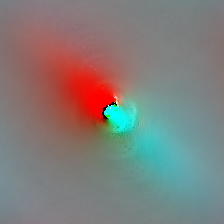

127.0.0.1 - - [05/Apr/2021 17:05:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 17:07:42] "POST /_dash-update-component HTTP/1.1" 200 -


update ranksdf_store triggered
Updating cached rank dfs with garbage_truck-small_SPANUpdating cached activations with garbage_truck_1000.JPEG

running model to fetch activations
running model to get ranks for "garbage_truck" on target "960"
target reached, breaking model forward pass in features_10
64
tensor(-1.8794, device='cuda:0', grad_fn=<SelectBackward>)
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-pack

127.0.0.1 - - [05/Apr/2021 17:07:43] "POST /_dash-update-component HTTP/1.1" 500 -


batch 0
target reached, breaking model forward pass in features_10
64
tensor(-2.0060, device='cuda:0', grad_fn=<SelectBackward>)
target node 960 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
64
tensor(-2.5274, device='cuda:0', grad_fn=<SelectBackward>)
target node 960 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
64
tensor(-2.0715, device='cuda:0', grad_fn=<SelectBackward>)
target node 960 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
64
tensor(-2.1519, device='cuda:0', grad_fn=<SelectBackward>)
target node 960 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_10
64
tensor(-2.2025, device='cuda:0', grad_fn=<SelectBackward>)
target node 960 reached, halted forward pass
batch 5
target reached, breaking model forward pass in features_10
64
tensor(-2.1495, device='cuda:0', grad_fn=<SelectBackward>)
t

127.0.0.1 - - [05/Apr/2021 17:07:56] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  0.778783   
1              1   features_0      0            0           1  0.000000   
2              2   features_0      0            0           2  0.000000   
3              3   features_0      0            1           0  0.267065   
4              4   features_0      0            1           1  0.783280   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.064230   
250044    250044  features_10      4          255         252  0.046858   
250045    250045  features_10      4          255         253  0.000002   
250046    250046  features_10      4          255         254  0.041891   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0        0.000004       0.000012  
1        

127.0.0.1 - - [05/Apr/2021 17:07:57] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '111', '24', '874', '960', '0']
building graph from browser "state"


127.0.0.1 - - [05/Apr/2021 17:07:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 17:08:05] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for r-0
found pre-generated edge image
generating feature_viz objective string for g-0
found pre-generated edge image
generating feature_viz objective string for b-0
found pre-generated edge image
CALLED: update_featviz
generating feature_viz objective string for 0


  0%|          | 0/512 [00:00<?, ?it/s]

generating featviz with objective: <lucent_edited.optvis.objectives.Objective object at 0x7ff7a3d35668>


100%|██████████| 512/512 [00:17<00:00, 28.56it/s]



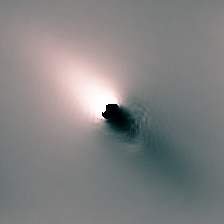

127.0.0.1 - - [05/Apr/2021 17:08:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 17:26:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 17:26:42] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click
CALLED: switch_edge_actmaps_click


127.0.0.1 - - [05/Apr/2021 17:26:43] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
CALLED: update_node_deepviz
generating feature_viz objective string for 825
CALLED: update_node_inputs
found pre-generated image
Updating cached activations with garbage_truck_1000.JPEG
running model to fetch activations
Updating cached activations with garbage_truck_1000.JPEG
running model to fetch activations


127.0.0.1 - - [05/Apr/2021 17:26:43] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_outmap
Updating cached activations with garbage_truck_1000.JPEG
running model to fetch activations
CALLED: update_store

TRIGGER edge-actmaps-input.value
g-21
changing selected node to 825
CALLED: update_edge_deepviz
generating feature_viz objective string for g-21
found pre-generated image
CALLED: update_edge_kernelmap


127.0.0.1 - - [05/Apr/2021 17:26:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 17:26:44] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmap
Updating cached activations with garbage_truck_1000.JPEG
running model to fetch activations


127.0.0.1 - - [05/Apr/2021 17:26:46] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '111', '24', '874', '960', '0', '825']
updating edge highlight to g-21
updating node highlight to 825
0 0 features_0


127.0.0.1 - - [05/Apr/2021 17:27:18] "POST /_dash-update-component HTTP/1.1" 200 -


Updating cached rank dfs with garbage_truck-small_SPAN
running model to get ranks for "garbage_truck" on target "960"


127.0.0.1 - - [05/Apr/2021 17:27:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Apr/2021 17:27:20] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
x_click
11
y_click
8
Receptive field size for layer features_8, unit_position (11, 8),  is 
 [(126.0, 224), (78.0, 209.0)]
normalized
[[5.625, 10.0], [3.482142857142857, 9.330357142857142]]
x points
[5.625, 5.625, 10.0, 10.0, 5.625]
y points
[6.517857142857142, 0.6696428571428577, 0.6696428571428577, 6.517857142857142, 6.517857142857142]
batch 0
target reached, breaking model forward pass in features_10
64
tensor(-2.0161, device='cuda:0', grad_fn=<SelectBackward>)
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1

127.0.0.1 - - [05/Apr/2021 17:27:20] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1936, in dispatch_request
    return self.view

127.0.0.1 - - [05/Apr/2021 17:27:20] "POST /_dash-update-component HTTP/1.1" 500 -


target node 960 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
64
tensor(-1.9182, device='cuda:0', grad_fn=<SelectBackward>)
target node 960 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
64
tensor(-1.9437, device='cuda:0', grad_fn=<SelectBackward>)
target node 960 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
64
tensor(-2.1041, device='cuda:0', grad_fn=<SelectBackward>)
target node 960 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_10
64
tensor(-2.5737, device='cuda:0', grad_fn=<SelectBackward>)
target node 960 reached, halted forward pass
batch 5
target reached, breaking model forward pass in features_10
64
tensor(-2.0964, device='cuda:0', grad_fn=<SelectBackward>)
target node 960 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_10
64
tensor(-1.9961,

127.0.0.1 - - [05/Apr/2021 17:27:35] "POST /_dash-update-component HTTP/1.1" 200 -


In [ ]:
app.run_server(port=8051)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
np.random.seed(0)
z1, z2, z3 = np.random.random((3, 7, 7))
print(z1.shape)
customdata = np.dstack((z2, z3))
print(customdata.shape)
fig = make_subplots(1, 2, subplot_titles=['z1', 'z2'])
fig.add_trace(go.Heatmap(
    z=z1,
    customdata=np.dstack((z2, z3)),
    hovertemplate='<b>z1:%{z:.3f}</b><br>z2:%{customdata[0]:.3f} <br>z3: %{customdata[1]:.3f} ',
    coloraxis="coloraxis1", name=''),
    1, 1)
fig.add_trace(go.Heatmap(
    z=z2,
    customdata=np.dstack((z1, z3)),
    hovertemplate='z1:%{customdata[0]:.3f} <br><b>z2:%{z:.3f}</b><br>z3: %{customdata[1]:.3f} ',
    coloraxis="coloraxis1", name=''),
    1, 2)
fig.update_layout(title_text='Hover to see the value of z1, z2 and z3 together')
fig.show()

In [ ]:
x = [1,2,3,4]
y = [1,2,'3',4]
z = np.stack((x,y),axis=-1)

z.shape